# N:1 MENT — marginal projections

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.sim import simulate
from ment.sim import copy_diagnostics
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj1D
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Settings

In [3]:
dist_name = "gaussian_mixture"
ndim = 6
xmax = 3.5
seed = 12345

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

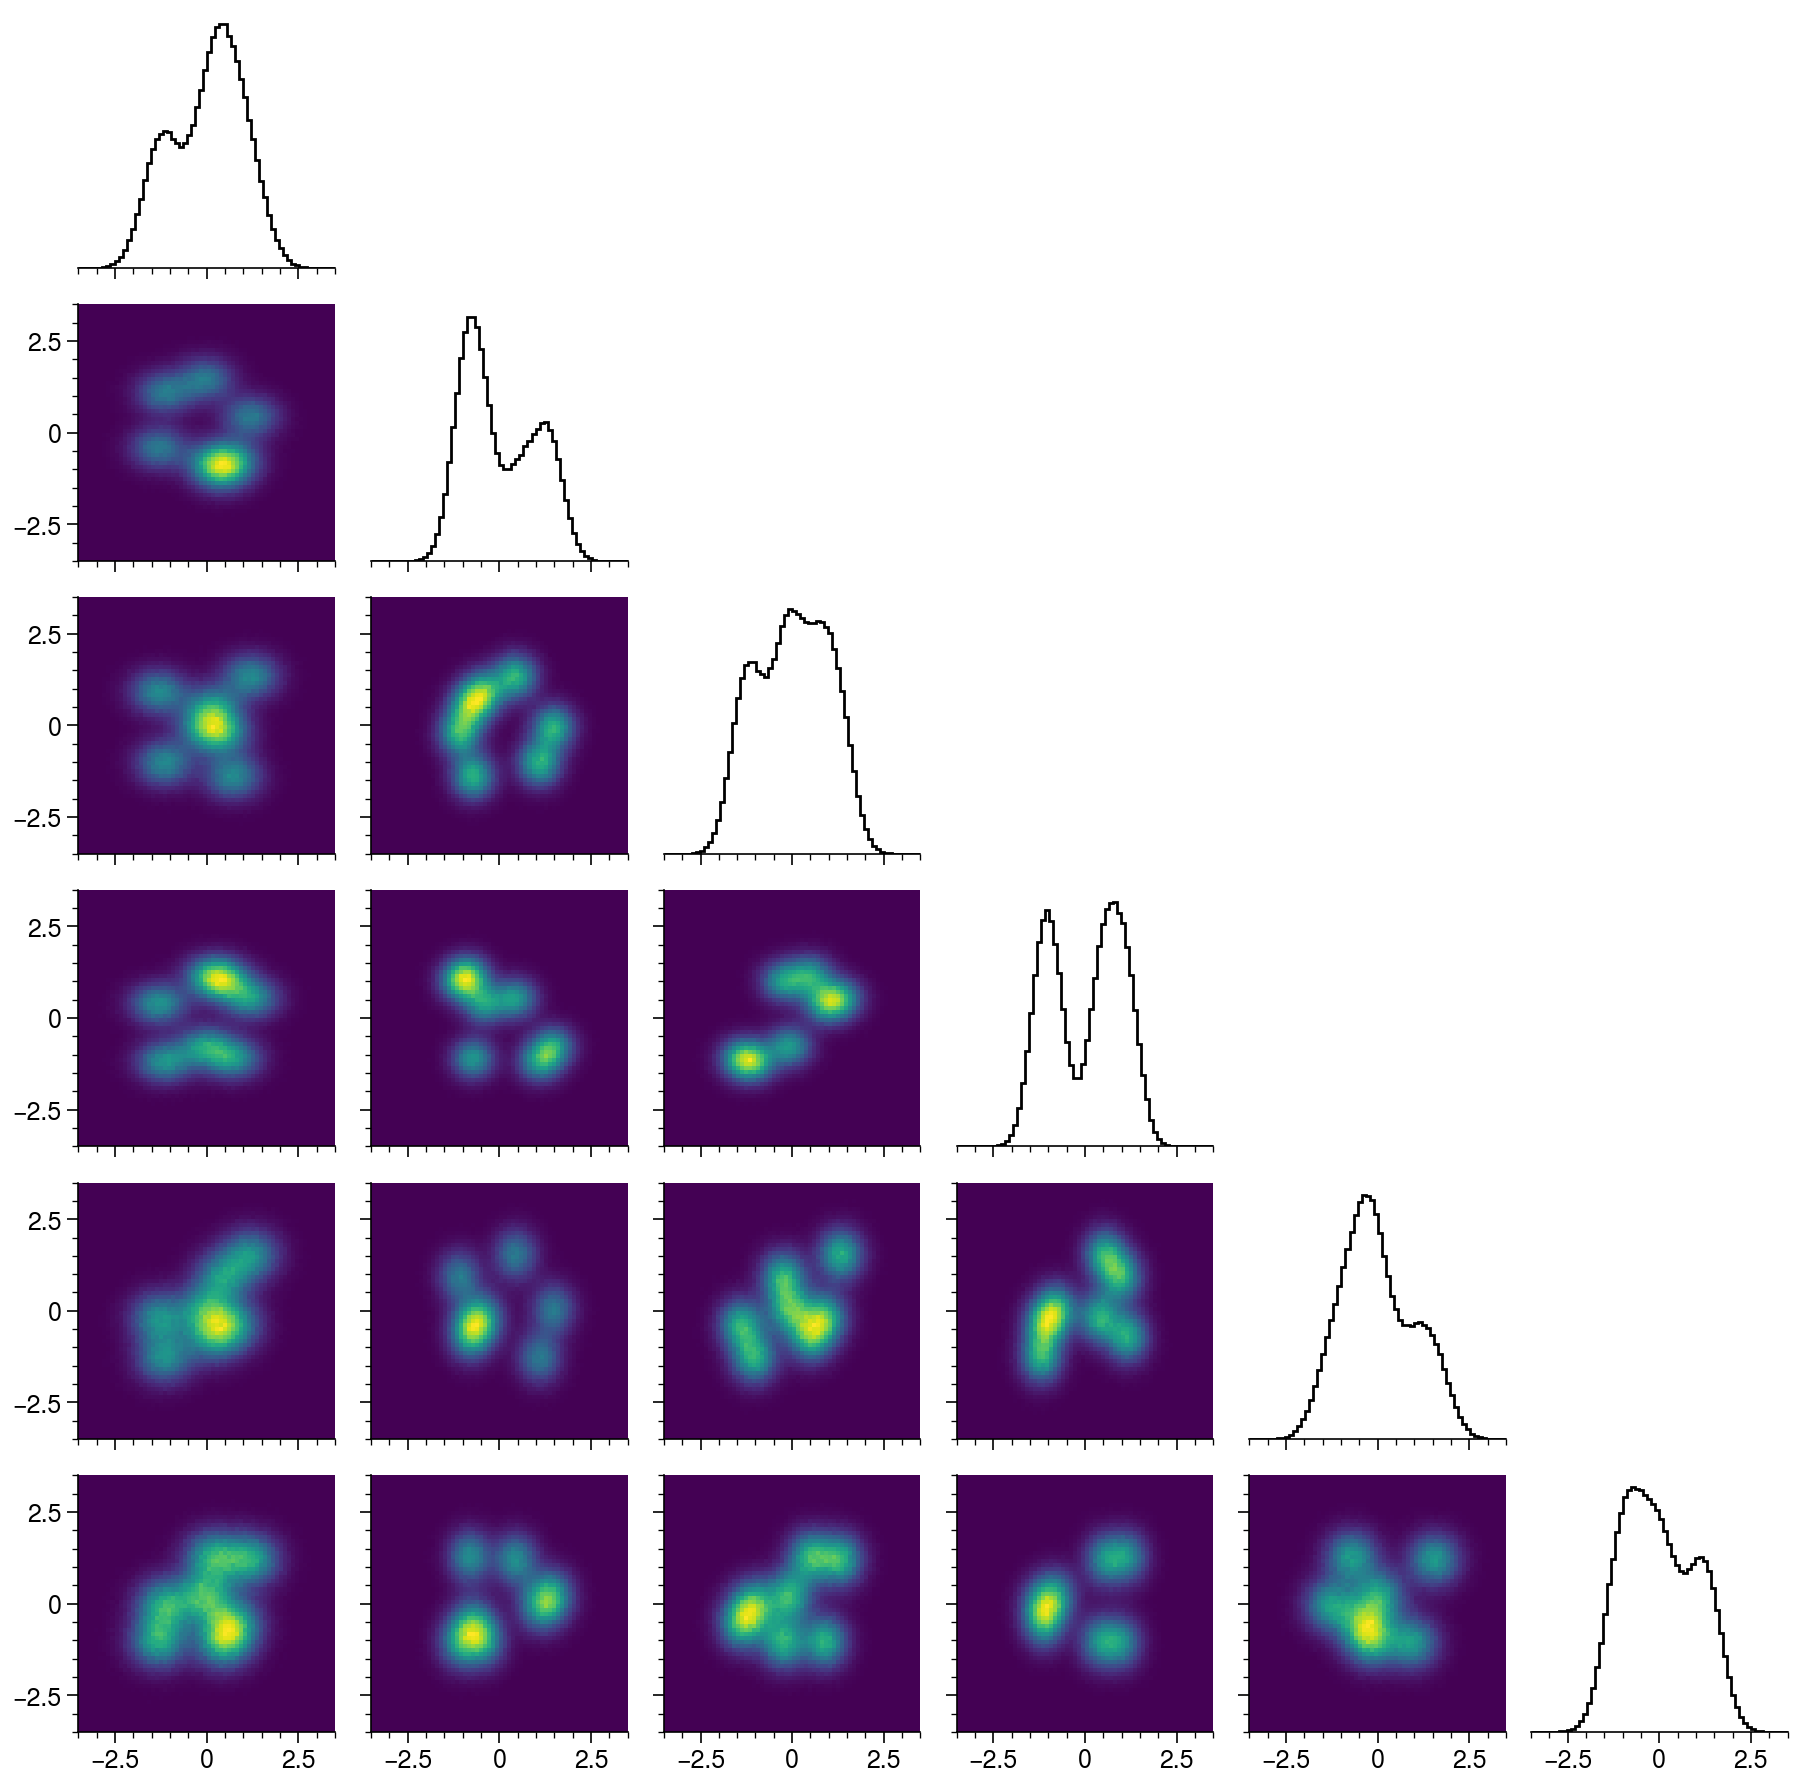

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
nmeas = 10
nbins = 64
kde = False
kde_bandwidth_frac = 1.0

In [7]:
class ProjectionTransform:
    def __init__(self, direction: np.ndarray) -> None:
        self.direction = direction

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return np.sum(x * self.direction, axis=1)[:, None]

In [8]:
transforms = []
directions = np.random.normal(size=(nmeas, ndim))
for direction in directions:
    direction = np.random.normal(size=ndim)
    direction = direction / np.linalg.norm(direction)
    transform = ProjectionTransform(direction)
    transforms.append(transform)

# Create histogram diagnostics
axis_proj = axis_meas = 0
bin_edges = np.linspace(-xmax, xmax, nbins + 1)

projections = []
for transform in transforms:
    projection = ment.diag.Histogram1D(
        axis=axis_meas, edges=bin_edges, kde=kde, kde_bandwidth_frac=kde_bandwidth_frac
    )
    projections.append([projection])

# Generate data.
projections = ment.sim.simulate_with_diag_update(
    x_true,
    transforms,
    projections,
    kde=False,
    blur=0.0,
)

## Reconstruction model

In [9]:
sampler = "mcmc"
nsamp = 500_000
burnin = 10_000

if sampler == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif sampler == "mcmc":
    sampler = ment.samp.MetropolisHastingsSampler(
        ndim=ndim,
        chains=248,
        proposal_cov=np.eye(ndim),
        burnin=burnin,
        shuffle=True,
        verbose=True,
    )
else:
    raise ValueError

In [10]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=nsamp,
    mode="sample",
    verbose=True,
)

## Training

In [11]:
plot_nsamp = 1_000_000
plot_nbins = 64

In [12]:
def plot_model(model):
    figs = []

    # Plot reconstructed distribution.
    x_pred = model.sample(1_000_000)

    grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25), diag_shrink=0.80)
    grid.plot(
        x_pred,
        limits=limits,
        bins=65,
        mask=False,
        cmap="viridis",
    )
    figs.append(grid.fig)

    # Plot simulated vs. measured projections.
    projections_true = ment.sim.copy_histograms(model.projections)
    projections_pred = ment.sim.copy_histograms(model.diagnostics)
    projections_pred = ment.sim.simulate(x_pred, transforms, projections_pred)

    ncols = min(nmeas, 7)
    nrows = int(np.ceil(nmeas / ncols))

    for log in [False, True]:
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(1.5 * ncols, 1.25 * nrows))
        for index, transform in enumerate(transforms):
            projection_true = unravel(projections_true)[index]
            projection_pred = unravel(projections_pred)[index]

            scale = np.max(projection_true.values.max())

            ax = axs[index]
            ax.plot(projection_true.coords, projection_true.values / scale, color="lightgray")
            ax.plot(
                projection_pred.coords,
                projection_pred.values / scale,
                color="black",
                marker=".",
                lw=0,
                ms=1.0,
            )
            ax.format(ymax=1.25, xlim=(-xmax, xmax))
            if log:
                ax.format(yscale="log", ymax=5.0, ymin=1.00e-05, yformatter="log")
        figs.append(fig)

    return figs

non numeric history values being saved


  0%|                                                                                                                                                               | 0/14031 [00:00<?, ?it/s]

  2%|██▋                                                                                                                                                | 253/14031 [00:00<00:05, 2526.42it/s]

  4%|█████▎                                                                                                                                             | 510/14031 [00:00<00:05, 2548.21it/s]

  5%|████████                                                                                                                                           | 768/14031 [00:00<00:05, 2560.64it/s]

  7%|██████████▋                                                                                                                                       | 1025/14031 [00:00<00:05, 2553.55it/s]

  9%|█████████████▍                                                                                                                                    | 1286/14031 [00:00<00:04, 2573.58it/s]

 11%|████████████████                                                                                                                                  | 1545/14031 [00:00<00:04, 2578.35it/s]

 13%|██████████████████▊                                                                                                                               | 1804/14031 [00:00<00:04, 2581.76it/s]

 15%|█████████████████████▍                                                                                                                            | 2063/14031 [00:00<00:04, 2573.93it/s]

 17%|████████████████████████▏                                                                                                                         | 2324/14031 [00:00<00:04, 2582.69it/s]

 18%|██████████████████████████▉                                                                                                                       | 2583/14031 [00:01<00:04, 2583.56it/s]

 20%|█████████████████████████████▌                                                                                                                    | 2844/14031 [00:01<00:04, 2589.20it/s]

 22%|████████████████████████████████▎                                                                                                                 | 3103/14031 [00:01<00:04, 2583.01it/s]

 24%|██████████████████████████████████▉                                                                                                               | 3362/14031 [00:01<00:04, 2577.68it/s]

 26%|█████████████████████████████████████▋                                                                                                            | 3621/14031 [00:01<00:04, 2578.31it/s]

 28%|████████████████████████████████████████▎                                                                                                         | 3879/14031 [00:01<00:03, 2564.67it/s]

 30%|███████████████████████████████████████████                                                                                                       | 4141/14031 [00:01<00:03, 2580.50it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 4402/14031 [00:01<00:03, 2586.78it/s]

 33%|████████████████████████████████████████████████▌                                                                                                 | 4664/14031 [00:01<00:03, 2594.07it/s]

 35%|███████████████████████████████████████████████████▎                                                                                              | 4928/14031 [00:01<00:03, 2607.78it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                            | 5189/14031 [00:02<00:03, 2603.19it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                         | 5450/14031 [00:02<00:03, 2587.69it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                      | 5713/14031 [00:02<00:03, 2598.89it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                   | 5974/14031 [00:02<00:03, 2601.20it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                 | 6235/14031 [00:02<00:03, 2585.83it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                              | 6494/14031 [00:02<00:02, 2581.28it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                           | 6754/14031 [00:02<00:02, 2586.76it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                         | 7013/14031 [00:02<00:02, 2584.11it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 7273/14031 [00:02<00:02, 2585.95it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 7532/14031 [00:02<00:02, 2584.27it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                                 | 7791/14031 [00:03<00:02, 2579.22it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                              | 8049/14031 [00:03<00:02, 2573.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                           | 8310/14031 [00:03<00:02, 2584.34it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 8571/14031 [00:03<00:02, 2591.95it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 8831/14031 [00:03<00:02, 2593.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 9091/14031 [00:03<00:01, 2591.21it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 9351/14031 [00:03<00:01, 2584.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 9610/14031 [00:03<00:01, 2575.72it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 9872/14031 [00:03<00:01, 2586.45it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 10134/14031 [00:03<00:01, 2593.79it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 10400/14031 [00:04<00:01, 2611.30it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 10662/14031 [00:04<00:01, 2609.60it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 10923/14031 [00:04<00:01, 2601.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 11184/14031 [00:04<00:01, 2595.04it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 11444/14031 [00:04<00:00, 2592.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 11704/14031 [00:04<00:00, 2584.65it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 11965/14031 [00:04<00:00, 2589.27it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 12224/14031 [00:04<00:00, 2576.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 12482/14031 [00:04<00:00, 2572.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 12744/14031 [00:04<00:00, 2584.66it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 13003/14031 [00:05<00:00, 2585.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 13264/14031 [00:05<00:00, 2591.92it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 13524/14031 [00:05<00:00, 2582.23it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 13785/14031 [00:05<00:00, 2590.43it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:05<00:00, 2585.77it/s]

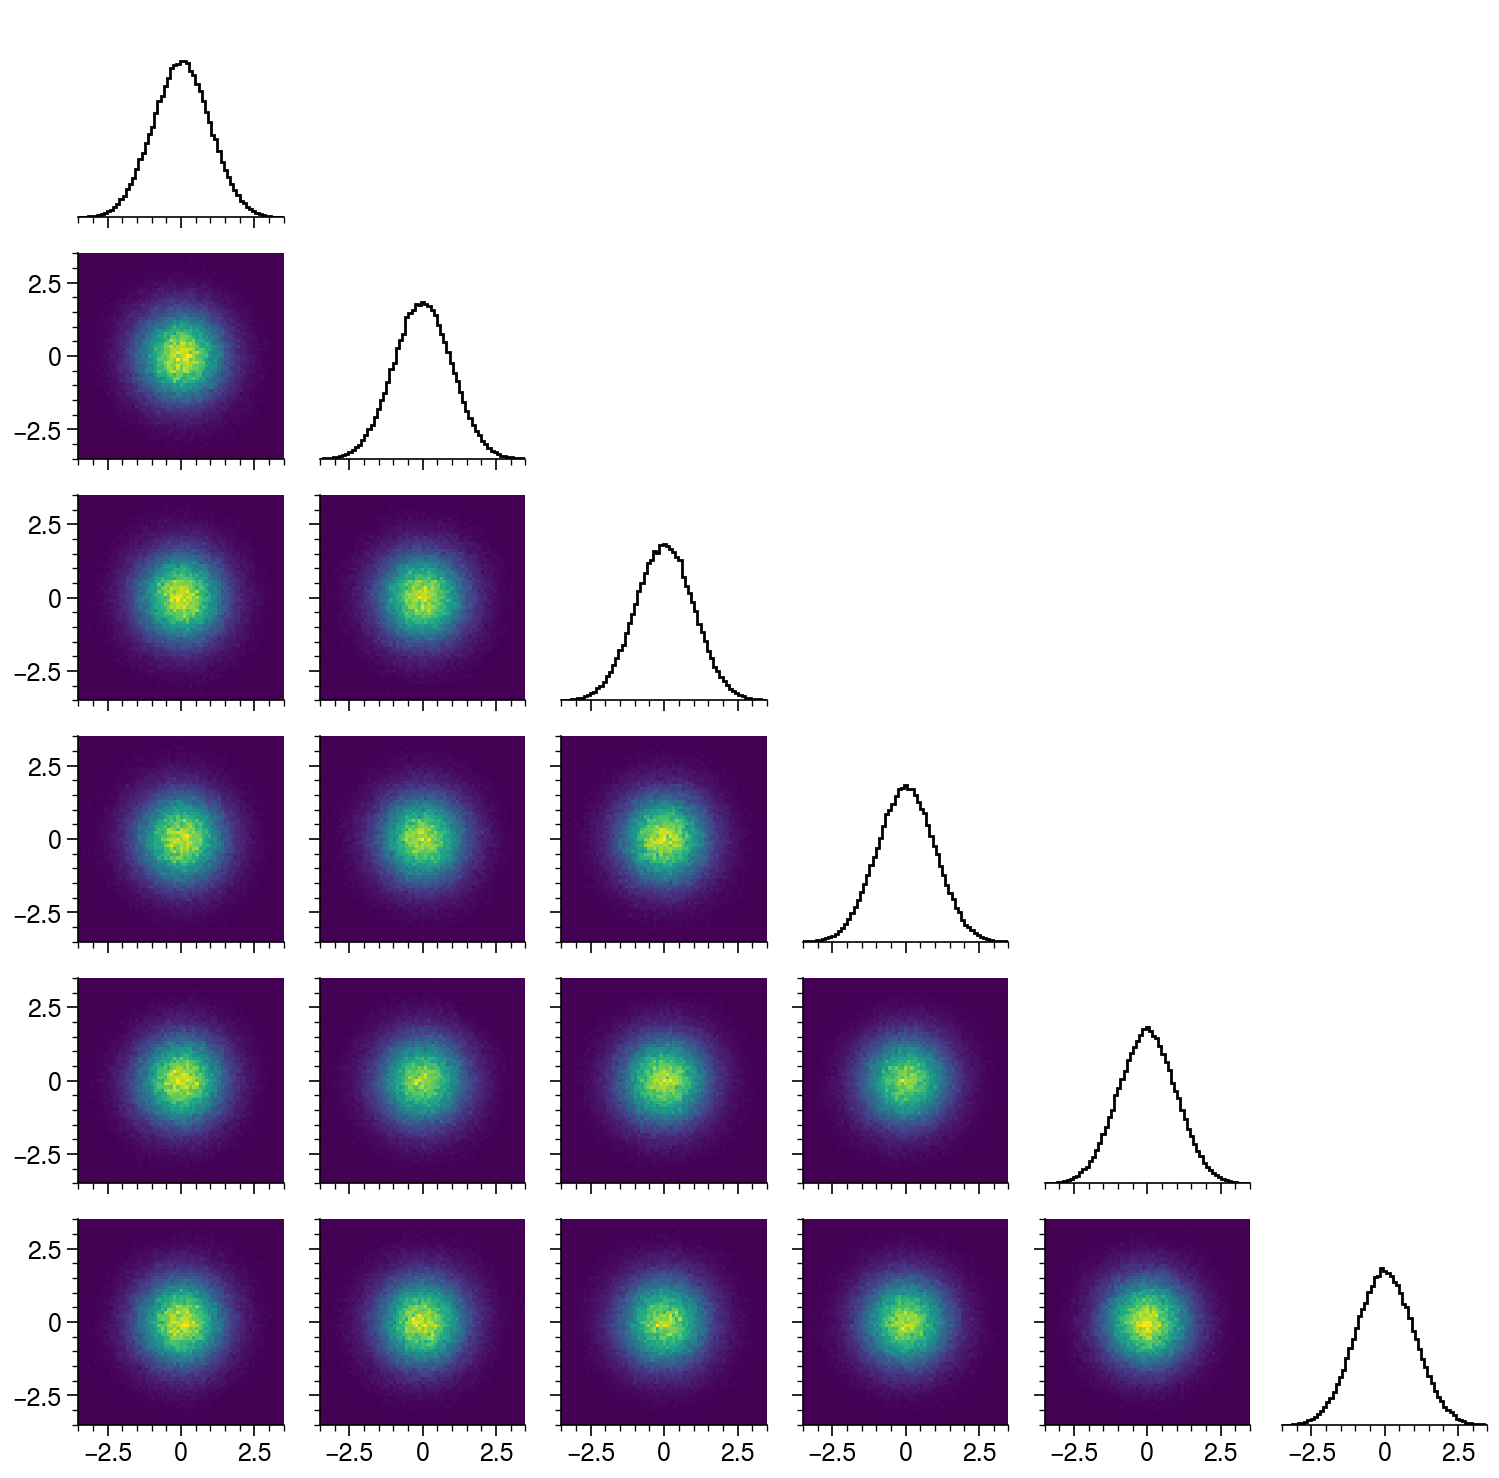

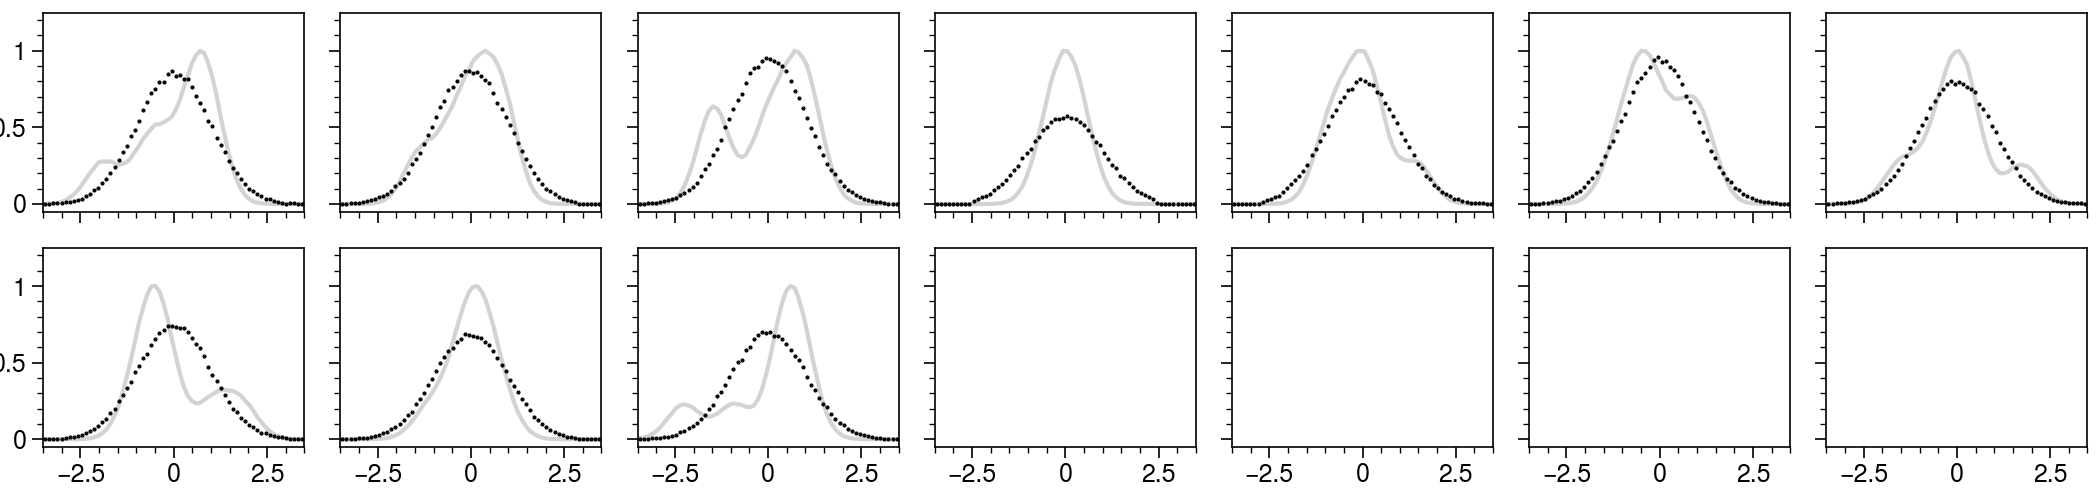

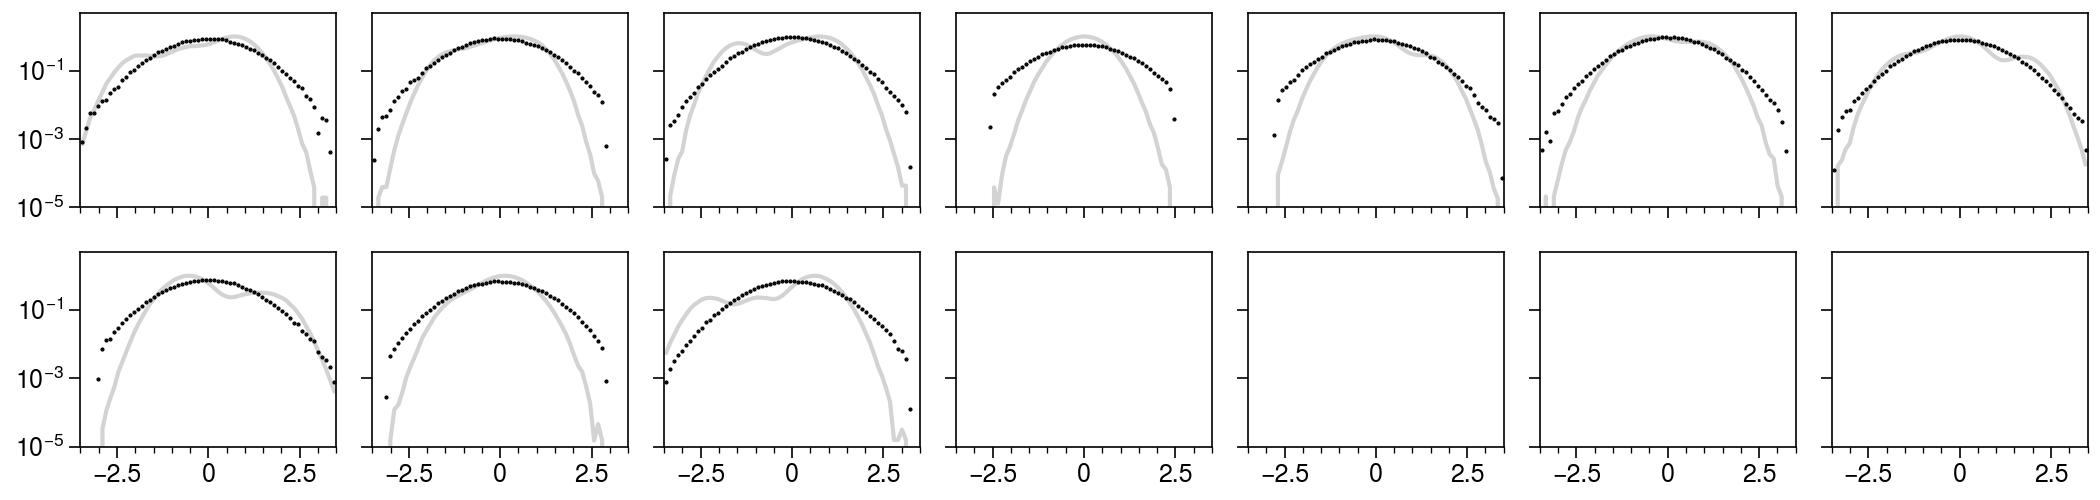

None
epoch = 1
transform=0
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███                                                                                                                                                | 254/12015 [00:00<00:04, 2532.32it/s]

  4%|██████▎                                                                                                                                            | 511/12015 [00:00<00:04, 2551.55it/s]

  6%|█████████▍                                                                                                                                         | 767/12015 [00:00<00:04, 2534.82it/s]

  8%|████████████▍                                                                                                                                     | 1021/12015 [00:00<00:04, 2534.59it/s]

 11%|███████████████▌                                                                                                                                  | 1278/12015 [00:00<00:04, 2545.57it/s]

 13%|██████████████████▋                                                                                                                               | 1536/12015 [00:00<00:04, 2556.54it/s]

 15%|█████████████████████▊                                                                                                                            | 1796/12015 [00:00<00:03, 2568.14it/s]

 17%|█████████████████████████                                                                                                                         | 2061/12015 [00:00<00:03, 2591.55it/s]

 19%|████████████████████████████▏                                                                                                                     | 2324/12015 [00:00<00:03, 2601.63it/s]

 22%|███████████████████████████████▍                                                                                                                  | 2585/12015 [00:01<00:03, 2597.23it/s]

 24%|██████████████████████████████████▌                                                                                                               | 2845/12015 [00:01<00:03, 2586.80it/s]

 26%|█████████████████████████████████████▋                                                                                                            | 3104/12015 [00:01<00:03, 2579.75it/s]

 28%|████████████████████████████████████████▊                                                                                                         | 3362/12015 [00:01<00:03, 2567.56it/s]

 30%|███████████████████████████████████████████▉                                                                                                      | 3619/12015 [00:01<00:03, 2564.64it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 3877/12015 [00:01<00:03, 2567.02it/s]

 34%|██████████████████████████████████████████████████▏                                                                                               | 4134/12015 [00:01<00:03, 2566.47it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                            | 4391/12015 [00:01<00:02, 2559.93it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                         | 4648/12015 [00:01<00:02, 2559.91it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                      | 4910/12015 [00:01<00:02, 2575.06it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 5168/12015 [00:02<00:02, 2573.16it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                | 5427/12015 [00:02<00:02, 2575.98it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                             | 5687/12015 [00:02<00:02, 2580.92it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                         | 5946/12015 [00:02<00:02, 2582.36it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                      | 6205/12015 [00:02<00:02, 2577.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▌                                                                   | 6463/12015 [00:02<00:02, 2574.30it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                | 6721/12015 [00:02<00:02, 2563.13it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                             | 6979/12015 [00:02<00:01, 2567.10it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                          | 7237/12015 [00:02<00:01, 2568.12it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 7501/12015 [00:02<00:01, 2587.30it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 7760/12015 [00:03<00:01, 2587.97it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 8020/12015 [00:03<00:01, 2589.51it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 8279/12015 [00:03<00:01, 2583.40it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 8538/12015 [00:03<00:01, 2585.11it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 8798/12015 [00:03<00:01, 2588.13it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 9057/12015 [00:03<00:01, 2587.81it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 9316/12015 [00:03<00:01, 2586.73it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 9578/12015 [00:03<00:00, 2596.13it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 9842/12015 [00:03<00:00, 2608.40it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 10103/12015 [00:03<00:00, 2608.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 10364/12015 [00:04<00:00, 2605.76it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 10625/12015 [00:04<00:00, 2601.26it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 10886/12015 [00:04<00:00, 2596.27it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 11147/12015 [00:04<00:00, 2597.44it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 11411/12015 [00:04<00:00, 2608.24it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 11672/12015 [00:04<00:00, 2600.61it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 11933/12015 [00:04<00:00, 2597.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2580.29it/s]

transform=1
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 258/12015 [00:00<00:04, 2573.03it/s]

  4%|██████▎                                                                                                                                            | 519/12015 [00:00<00:04, 2594.72it/s]

  6%|█████████▌                                                                                                                                         | 779/12015 [00:00<00:04, 2562.44it/s]

  9%|████████████▌                                                                                                                                     | 1036/12015 [00:00<00:04, 2555.51it/s]

 11%|███████████████▋                                                                                                                                  | 1296/12015 [00:00<00:04, 2568.45it/s]

 13%|██████████████████▊                                                                                                                               | 1553/12015 [00:00<00:04, 2566.07it/s]

 15%|██████████████████████                                                                                                                            | 1813/12015 [00:00<00:03, 2574.10it/s]

 17%|█████████████████████████▏                                                                                                                        | 2071/12015 [00:00<00:03, 2573.72it/s]

 19%|████████████████████████████▎                                                                                                                     | 2329/12015 [00:00<00:03, 2572.79it/s]

 22%|███████████████████████████████▍                                                                                                                  | 2591/12015 [00:01<00:03, 2585.10it/s]

 24%|██████████████████████████████████▋                                                                                                               | 2853/12015 [00:01<00:03, 2595.75it/s]

 26%|█████████████████████████████████████▊                                                                                                            | 3114/12015 [00:01<00:03, 2597.16it/s]

 28%|████████████████████████████████████████▉                                                                                                         | 3374/12015 [00:01<00:03, 2587.25it/s]

 30%|████████████████████████████████████████████▏                                                                                                     | 3636/12015 [00:01<00:03, 2595.53it/s]

 32%|███████████████████████████████████████████████▎                                                                                                  | 3896/12015 [00:01<00:03, 2594.73it/s]

 35%|██████████████████████████████████████████████████▌                                                                                               | 4156/12015 [00:01<00:03, 2591.57it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                            | 4416/12015 [00:01<00:02, 2592.46it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                         | 4676/12015 [00:01<00:02, 2592.93it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                      | 4936/12015 [00:01<00:02, 2582.27it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                  | 5199/12015 [00:02<00:02, 2593.87it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                               | 5465/12015 [00:02<00:02, 2612.94it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                            | 5727/12015 [00:02<00:02, 2605.24it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                         | 5988/12015 [00:02<00:02, 2599.95it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 6250/12015 [00:02<00:02, 2605.12it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 6517/12015 [00:02<00:02, 2621.78it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▍                                                               | 6784/12015 [00:02<00:01, 2633.82it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                            | 7048/12015 [00:02<00:01, 2631.69it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 7312/12015 [00:02<00:01, 2622.38it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                      | 7575/12015 [00:02<00:01, 2614.19it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 7837/12015 [00:03<00:01, 2613.07it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 8099/12015 [00:03<00:01, 2612.52it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 8361/12015 [00:03<00:01, 2610.96it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 8623/12015 [00:03<00:01, 2604.71it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 8884/12015 [00:03<00:01, 2605.43it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 9145/12015 [00:03<00:01, 2598.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 9406/12015 [00:03<00:01, 2601.48it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 9668/12015 [00:03<00:00, 2604.45it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 9929/12015 [00:03<00:00, 2603.14it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 10191/12015 [00:03<00:00, 2605.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 10453/12015 [00:04<00:00, 2608.09it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 10714/12015 [00:04<00:00, 2605.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 10975/12015 [00:04<00:00, 2603.60it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11236/12015 [00:04<00:00, 2605.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 11497/12015 [00:04<00:00, 2601.79it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 11758/12015 [00:04<00:00, 2602.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2599.62it/s]

transform=2
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 259/12015 [00:00<00:04, 2589.79it/s]

  4%|██████▎                                                                                                                                            | 519/12015 [00:00<00:04, 2592.41it/s]

  7%|█████████▌                                                                                                                                         | 783/12015 [00:00<00:04, 2612.24it/s]

  9%|████████████▋                                                                                                                                     | 1045/12015 [00:00<00:04, 2614.97it/s]

 11%|███████████████▉                                                                                                                                  | 1309/12015 [00:00<00:04, 2620.63it/s]

 13%|███████████████████▏                                                                                                                              | 1574/12015 [00:00<00:03, 2629.08it/s]

 15%|██████████████████████▎                                                                                                                           | 1839/12015 [00:00<00:03, 2634.44it/s]

 18%|█████████████████████████▌                                                                                                                        | 2103/12015 [00:00<00:03, 2615.14it/s]

 20%|████████████████████████████▋                                                                                                                     | 2365/12015 [00:00<00:03, 2610.55it/s]

 22%|███████████████████████████████▉                                                                                                                  | 2629/12015 [00:01<00:03, 2618.12it/s]

 24%|███████████████████████████████████▏                                                                                                              | 2891/12015 [00:01<00:03, 2611.29it/s]

 26%|██████████████████████████████████████▎                                                                                                           | 3153/12015 [00:01<00:03, 2608.35it/s]

 28%|█████████████████████████████████████████▍                                                                                                        | 3414/12015 [00:01<00:03, 2599.28it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 3674/12015 [00:01<00:03, 2586.34it/s]

 33%|███████████████████████████████████████████████▊                                                                                                  | 3934/12015 [00:01<00:03, 2587.55it/s]

 35%|██████████████████████████████████████████████████▉                                                                                               | 4195/12015 [00:01<00:03, 2592.71it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                           | 4460/12015 [00:01<00:02, 2607.85it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                        | 4725/12015 [00:01<00:02, 2619.50it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                     | 4987/12015 [00:01<00:02, 2615.53it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                  | 5249/12015 [00:02<00:02, 2608.34it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                               | 5510/12015 [00:02<00:02, 2604.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                           | 5771/12015 [00:02<00:02, 2599.46it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                        | 6036/12015 [00:02<00:02, 2614.47it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                     | 6300/12015 [00:02<00:02, 2619.67it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 6562/12015 [00:02<00:02, 2609.32it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                               | 6823/12015 [00:02<00:01, 2600.08it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                            | 7084/12015 [00:02<00:01, 2598.60it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 7345/12015 [00:02<00:01, 2600.48it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 7606/12015 [00:02<00:01, 2601.91it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 7869/12015 [00:03<00:01, 2608.25it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 8133/12015 [00:03<00:01, 2616.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 8397/12015 [00:03<00:01, 2621.57it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 8662/12015 [00:03<00:01, 2628.33it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 8927/12015 [00:03<00:01, 2633.41it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 9191/12015 [00:03<00:01, 2632.45it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 9455/12015 [00:03<00:00, 2620.05it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 9718/12015 [00:03<00:00, 2615.22it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 9980/12015 [00:03<00:00, 2610.26it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 10243/12015 [00:03<00:00, 2615.97it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 10506/12015 [00:04<00:00, 2619.14it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 10770/12015 [00:04<00:00, 2623.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 11035/12015 [00:04<00:00, 2629.00it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 11299/12015 [00:04<00:00, 2631.03it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 11563/12015 [00:04<00:00, 2623.16it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 11826/12015 [00:04<00:00, 2613.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2612.64it/s]

transform=3
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 264/12015 [00:00<00:04, 2637.39it/s]

  4%|██████▍                                                                                                                                            | 528/12015 [00:00<00:04, 2620.22it/s]

  7%|█████████▋                                                                                                                                         | 791/12015 [00:00<00:04, 2618.40it/s]

  9%|████████████▊                                                                                                                                     | 1054/12015 [00:00<00:04, 2620.66it/s]

 11%|████████████████                                                                                                                                  | 1318/12015 [00:00<00:04, 2625.27it/s]

 13%|███████████████████▏                                                                                                                              | 1581/12015 [00:00<00:03, 2623.16it/s]

 15%|██████████████████████▍                                                                                                                           | 1844/12015 [00:00<00:03, 2612.96it/s]

 18%|█████████████████████████▌                                                                                                                        | 2106/12015 [00:00<00:03, 2601.74it/s]

 20%|████████████████████████████▊                                                                                                                     | 2367/12015 [00:00<00:03, 2596.73it/s]

 22%|███████████████████████████████▉                                                                                                                  | 2627/12015 [00:01<00:03, 2594.31it/s]

 24%|███████████████████████████████████                                                                                                               | 2887/12015 [00:01<00:03, 2595.49it/s]

 26%|██████████████████████████████████████▎                                                                                                           | 3151/12015 [00:01<00:03, 2606.32it/s]

 28%|█████████████████████████████████████████▍                                                                                                        | 3415/12015 [00:01<00:03, 2615.83it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 3678/12015 [00:01<00:03, 2618.70it/s]

 33%|███████████████████████████████████████████████▉                                                                                                  | 3943/12015 [00:01<00:03, 2628.04it/s]

 35%|███████████████████████████████████████████████████                                                                                               | 4207/12015 [00:01<00:02, 2628.91it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 4470/12015 [00:01<00:02, 2625.55it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                        | 4736/12015 [00:01<00:02, 2634.02it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                     | 5000/12015 [00:01<00:02, 2634.09it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                  | 5266/12015 [00:02<00:02, 2639.80it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 5533/12015 [00:02<00:02, 2646.40it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                           | 5798/12015 [00:02<00:02, 2642.60it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                        | 6063/12015 [00:02<00:02, 2639.25it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                     | 6329/12015 [00:02<00:02, 2642.75it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 6595/12015 [00:02<00:02, 2645.37it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                              | 6862/12015 [00:02<00:01, 2649.93it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                           | 7129/12015 [00:02<00:01, 2653.16it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 7395/12015 [00:02<00:01, 2641.06it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████                                                     | 7660/12015 [00:02<00:01, 2625.40it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 7924/12015 [00:03<00:01, 2629.35it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 8189/12015 [00:03<00:01, 2635.25it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 8454/12015 [00:03<00:01, 2639.02it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 8718/12015 [00:03<00:01, 2623.38it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 8983/12015 [00:03<00:01, 2629.58it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 9246/12015 [00:03<00:01, 2626.96it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 9509/12015 [00:03<00:00, 2620.00it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 9772/12015 [00:03<00:00, 2615.03it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 10034/12015 [00:03<00:00, 2611.52it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 10297/12015 [00:03<00:00, 2614.35it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 10559/12015 [00:04<00:00, 2613.90it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 10822/12015 [00:04<00:00, 2616.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 11085/12015 [00:04<00:00, 2619.39it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 11347/12015 [00:04<00:00, 2614.60it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 11609/12015 [00:04<00:00, 2586.41it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 11872/12015 [00:04<00:00, 2596.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2621.67it/s]

transform=4
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 261/12015 [00:00<00:04, 2607.25it/s]

  4%|██████▍                                                                                                                                            | 522/12015 [00:00<00:04, 2603.25it/s]

  7%|█████████▌                                                                                                                                         | 783/12015 [00:00<00:04, 2605.17it/s]

  9%|████████████▋                                                                                                                                     | 1044/12015 [00:00<00:04, 2602.38it/s]

 11%|███████████████▊                                                                                                                                  | 1305/12015 [00:00<00:04, 2576.71it/s]

 13%|██████████████████▉                                                                                                                               | 1563/12015 [00:00<00:04, 2565.75it/s]

 15%|██████████████████████▏                                                                                                                           | 1826/12015 [00:00<00:03, 2584.35it/s]

 17%|█████████████████████████▍                                                                                                                        | 2091/12015 [00:00<00:03, 2602.13it/s]

 20%|████████████████████████████▌                                                                                                                     | 2355/12015 [00:00<00:03, 2611.02it/s]

 22%|███████████████████████████████▊                                                                                                                  | 2617/12015 [00:01<00:03, 2612.42it/s]

 24%|██████████████████████████████████▉                                                                                                               | 2880/12015 [00:01<00:03, 2617.22it/s]

 26%|██████████████████████████████████████▏                                                                                                           | 3143/12015 [00:01<00:03, 2620.25it/s]

 28%|█████████████████████████████████████████▍                                                                                                        | 3407/12015 [00:01<00:03, 2624.97it/s]

 31%|████████████████████████████████████████████▌                                                                                                     | 3670/12015 [00:01<00:03, 2612.00it/s]

 33%|███████████████████████████████████████████████▊                                                                                                  | 3934/12015 [00:01<00:03, 2620.16it/s]

 35%|███████████████████████████████████████████████████                                                                                               | 4201/12015 [00:01<00:02, 2634.23it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 4467/12015 [00:01<00:02, 2640.67it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                        | 4734/12015 [00:01<00:02, 2646.99it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                     | 5000/12015 [00:01<00:02, 2649.26it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                  | 5265/12015 [00:02<00:02, 2626.65it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 5528/12015 [00:02<00:02, 2626.24it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                           | 5791/12015 [00:02<00:02, 2624.78it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 6057/12015 [00:02<00:02, 2634.32it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                     | 6323/12015 [00:02<00:02, 2641.06it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 6588/12015 [00:02<00:02, 2643.08it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                              | 6853/12015 [00:02<00:01, 2631.66it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                           | 7118/12015 [00:02<00:01, 2634.78it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 7383/12015 [00:02<00:01, 2636.65it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7647/12015 [00:02<00:01, 2615.56it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 7909/12015 [00:03<00:01, 2614.50it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 8171/12015 [00:03<00:01, 2613.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 8434/12015 [00:03<00:01, 2616.55it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 8698/12015 [00:03<00:01, 2621.63it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 8963/12015 [00:03<00:01, 2630.07it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 9230/12015 [00:03<00:01, 2640.76it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 9495/12015 [00:03<00:00, 2643.00it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 9760/12015 [00:03<00:00, 2630.97it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 10024/12015 [00:03<00:00, 2623.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 10289/12015 [00:03<00:00, 2629.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 10555/12015 [00:04<00:00, 2638.04it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 10819/12015 [00:04<00:00, 2634.63it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 11083/12015 [00:04<00:00, 2623.39it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 11349/12015 [00:04<00:00, 2632.51it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 11615/12015 [00:04<00:00, 2640.24it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 11881/12015 [00:04<00:00, 2645.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2625.36it/s]

transform=5
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 262/12015 [00:00<00:04, 2611.93it/s]

  4%|██████▍                                                                                                                                            | 527/12015 [00:00<00:04, 2632.89it/s]

  7%|█████████▋                                                                                                                                         | 793/12015 [00:00<00:04, 2644.10it/s]

  9%|████████████▉                                                                                                                                     | 1060/12015 [00:00<00:04, 2651.02it/s]

 11%|████████████████                                                                                                                                  | 1326/12015 [00:00<00:04, 2622.48it/s]

 13%|███████████████████▎                                                                                                                              | 1589/12015 [00:00<00:04, 2601.37it/s]

 15%|██████████████████████▍                                                                                                                           | 1850/12015 [00:00<00:03, 2603.97it/s]

 18%|█████████████████████████▋                                                                                                                        | 2116/12015 [00:00<00:03, 2619.83it/s]

 20%|████████████████████████████▉                                                                                                                     | 2383/12015 [00:00<00:03, 2634.87it/s]

 22%|████████████████████████████████▏                                                                                                                 | 2648/12015 [00:01<00:03, 2636.71it/s]

 24%|███████████████████████████████████▍                                                                                                              | 2914/12015 [00:01<00:03, 2641.89it/s]

 26%|██████████████████████████████████████▋                                                                                                           | 3179/12015 [00:01<00:03, 2643.42it/s]

 29%|█████████████████████████████████████████▊                                                                                                        | 3446/12015 [00:01<00:03, 2649.49it/s]

 31%|█████████████████████████████████████████████                                                                                                     | 3712/12015 [00:01<00:03, 2651.15it/s]

 33%|████████████████████████████████████████████████▎                                                                                                 | 3978/12015 [00:01<00:03, 2644.36it/s]

 35%|███████████████████████████████████████████████████▌                                                                                              | 4244/12015 [00:01<00:02, 2646.20it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                           | 4509/12015 [00:01<00:02, 2646.62it/s]

 40%|██████████████████████████████████████████████████████████                                                                                        | 4776/12015 [00:01<00:02, 2653.61it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                    | 5042/12015 [00:01<00:02, 2653.97it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 5308/12015 [00:02<00:02, 2647.52it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                              | 5573/12015 [00:02<00:02, 2638.09it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                           | 5839/12015 [00:02<00:02, 2644.61it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                       | 6104/12015 [00:02<00:02, 2644.16it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 6371/12015 [00:02<00:02, 2650.20it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                 | 6637/12015 [00:02<00:02, 2650.01it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                              | 6903/12015 [00:02<00:01, 2652.96it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                           | 7169/12015 [00:02<00:01, 2652.12it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 7436/12015 [00:02<00:01, 2654.79it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 7703/12015 [00:02<00:01, 2657.95it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 7969/12015 [00:03<00:01, 2658.48it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 8236/12015 [00:03<00:01, 2659.66it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 8502/12015 [00:03<00:01, 2659.06it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 8769/12015 [00:03<00:01, 2660.61it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 9036/12015 [00:03<00:01, 2660.73it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 9303/12015 [00:03<00:01, 2655.26it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 9570/12015 [00:03<00:00, 2658.29it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 9836/12015 [00:03<00:00, 2646.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 10103/12015 [00:03<00:00, 2651.60it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 10370/12015 [00:03<00:00, 2655.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 10636/12015 [00:04<00:00, 2652.50it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 10902/12015 [00:04<00:00, 2643.57it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 11167/12015 [00:04<00:00, 2631.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 11431/12015 [00:04<00:00, 2630.64it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 11695/12015 [00:04<00:00, 2627.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 11959/12015 [00:04<00:00, 2628.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2643.33it/s]

transform=6
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 260/12015 [00:00<00:04, 2592.55it/s]

  4%|██████▍                                                                                                                                            | 523/12015 [00:00<00:04, 2614.42it/s]

  7%|█████████▋                                                                                                                                         | 787/12015 [00:00<00:04, 2625.11it/s]

  9%|████████████▊                                                                                                                                     | 1052/12015 [00:00<00:04, 2632.49it/s]

 11%|████████████████                                                                                                                                  | 1318/12015 [00:00<00:04, 2641.65it/s]

 13%|███████████████████▎                                                                                                                              | 1585/12015 [00:00<00:03, 2648.03it/s]

 15%|██████████████████████▍                                                                                                                           | 1851/12015 [00:00<00:03, 2650.27it/s]

 18%|█████████████████████████▋                                                                                                                        | 2117/12015 [00:00<00:03, 2648.44it/s]

 20%|████████████████████████████▉                                                                                                                     | 2382/12015 [00:00<00:03, 2645.74it/s]

 22%|████████████████████████████████▏                                                                                                                 | 2648/12015 [00:01<00:03, 2648.78it/s]

 24%|███████████████████████████████████▍                                                                                                              | 2914/12015 [00:01<00:03, 2650.84it/s]

 26%|██████████████████████████████████████▋                                                                                                           | 3180/12015 [00:01<00:03, 2647.79it/s]

 29%|█████████████████████████████████████████▊                                                                                                        | 3446/12015 [00:01<00:03, 2650.97it/s]

 31%|█████████████████████████████████████████████                                                                                                     | 3712/12015 [00:01<00:03, 2646.09it/s]

 33%|████████████████████████████████████████████████▎                                                                                                 | 3977/12015 [00:01<00:03, 2601.79it/s]

 35%|███████████████████████████████████████████████████▍                                                                                              | 4238/12015 [00:01<00:03, 2583.84it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                           | 4500/12015 [00:01<00:02, 2592.48it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                        | 4764/12015 [00:01<00:02, 2604.55it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                     | 5025/12015 [00:01<00:02, 2604.94it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 5286/12015 [00:02<00:02, 2595.63it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                              | 5546/12015 [00:02<00:02, 2590.43it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                           | 5808/12015 [00:02<00:02, 2597.46it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                        | 6068/12015 [00:02<00:02, 2591.77it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                     | 6330/12015 [00:02<00:02, 2599.27it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 6590/12015 [00:02<00:02, 2589.22it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                              | 6849/12015 [00:02<00:01, 2585.84it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                           | 7113/12015 [00:02<00:01, 2599.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 7377/12015 [00:02<00:01, 2610.84it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 7640/12015 [00:02<00:01, 2615.64it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 7902/12015 [00:03<00:01, 2611.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 8164/12015 [00:03<00:01, 2604.76it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 8425/12015 [00:03<00:01, 2591.18it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 8685/12015 [00:03<00:01, 2584.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 8946/12015 [00:03<00:01, 2591.73it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 9209/12015 [00:03<00:01, 2602.80it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 9470/12015 [00:03<00:00, 2600.13it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 9731/12015 [00:03<00:00, 2598.56it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 9991/12015 [00:03<00:00, 2582.39it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 10250/12015 [00:03<00:00, 2569.96it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 10508/12015 [00:04<00:00, 2569.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 10765/12015 [00:04<00:00, 2563.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 11025/12015 [00:04<00:00, 2573.50it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 11293/12015 [00:04<00:00, 2602.50it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 11555/12015 [00:04<00:00, 2605.80it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 11819/12015 [00:04<00:00, 2614.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2608.58it/s]

transform=7
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 263/12015 [00:00<00:04, 2620.57it/s]

  4%|██████▍                                                                                                                                            | 526/12015 [00:00<00:04, 2607.76it/s]

  7%|█████████▋                                                                                                                                         | 791/12015 [00:00<00:04, 2626.33it/s]

  9%|████████████▊                                                                                                                                     | 1058/12015 [00:00<00:04, 2641.20it/s]

 11%|████████████████                                                                                                                                  | 1323/12015 [00:00<00:04, 2631.70it/s]

 13%|███████████████████▎                                                                                                                              | 1587/12015 [00:00<00:03, 2610.71it/s]

 15%|██████████████████████▍                                                                                                                           | 1850/12015 [00:00<00:03, 2614.19it/s]

 18%|█████████████████████████▋                                                                                                                        | 2112/12015 [00:00<00:03, 2611.24it/s]

 20%|████████████████████████████▊                                                                                                                     | 2374/12015 [00:00<00:03, 2610.74it/s]

 22%|████████████████████████████████                                                                                                                  | 2636/12015 [00:01<00:03, 2612.72it/s]

 24%|███████████████████████████████████▎                                                                                                              | 2902/12015 [00:01<00:03, 2626.16it/s]

 26%|██████████████████████████████████████▍                                                                                                           | 3165/12015 [00:01<00:03, 2625.42it/s]

 29%|█████████████████████████████████████████▋                                                                                                        | 3428/12015 [00:01<00:03, 2624.91it/s]

 31%|████████████████████████████████████████████▊                                                                                                     | 3691/12015 [00:01<00:03, 2623.63it/s]

 33%|████████████████████████████████████████████████                                                                                                  | 3954/12015 [00:01<00:03, 2623.09it/s]

 35%|███████████████████████████████████████████████████▏                                                                                              | 4217/12015 [00:01<00:02, 2609.82it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                           | 4478/12015 [00:01<00:02, 2599.35it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                        | 4738/12015 [00:01<00:02, 2593.42it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                     | 4998/12015 [00:01<00:02, 2592.89it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                  | 5258/12015 [00:02<00:02, 2589.23it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                               | 5518/12015 [00:02<00:02, 2590.04it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                           | 5778/12015 [00:02<00:02, 2587.91it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                        | 6039/12015 [00:02<00:02, 2593.46it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                     | 6305/12015 [00:02<00:02, 2612.82it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                  | 6568/12015 [00:02<00:02, 2617.58it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                               | 6830/12015 [00:02<00:01, 2610.71it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                           | 7092/12015 [00:02<00:01, 2601.56it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 7353/12015 [00:02<00:01, 2598.95it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 7613/12015 [00:02<00:01, 2596.93it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 7874/12015 [00:03<00:01, 2599.68it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 8134/12015 [00:03<00:01, 2598.21it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 8394/12015 [00:03<00:01, 2596.62it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 8654/12015 [00:03<00:01, 2593.50it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 8914/12015 [00:03<00:01, 2593.01it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 9174/12015 [00:03<00:01, 2589.31it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 9438/12015 [00:03<00:00, 2603.45it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 9699/12015 [00:03<00:00, 2595.09it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 9959/12015 [00:03<00:00, 2593.28it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 10224/12015 [00:03<00:00, 2609.80it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 10488/12015 [00:04<00:00, 2618.28it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 10750/12015 [00:04<00:00, 2613.46it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 11012/12015 [00:04<00:00, 2612.65it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 11276/12015 [00:04<00:00, 2618.47it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 11538/12015 [00:04<00:00, 2617.62it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 11804/12015 [00:04<00:00, 2629.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2609.93it/s]

transform=8
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 259/12015 [00:00<00:04, 2586.89it/s]

  4%|██████▎                                                                                                                                            | 518/12015 [00:00<00:04, 2578.95it/s]

  6%|█████████▍                                                                                                                                         | 776/12015 [00:00<00:04, 2576.53it/s]

  9%|████████████▌                                                                                                                                     | 1035/12015 [00:00<00:04, 2577.94it/s]

 11%|███████████████▋                                                                                                                                  | 1293/12015 [00:00<00:04, 2577.90it/s]

 13%|██████████████████▉                                                                                                                               | 1554/12015 [00:00<00:04, 2585.64it/s]

 15%|██████████████████████                                                                                                                            | 1813/12015 [00:00<00:03, 2577.60it/s]

 17%|█████████████████████████▏                                                                                                                        | 2071/12015 [00:00<00:03, 2566.89it/s]

 19%|████████████████████████████▎                                                                                                                     | 2330/12015 [00:00<00:03, 2573.84it/s]

 22%|███████████████████████████████▍                                                                                                                  | 2588/12015 [00:01<00:03, 2574.56it/s]

 24%|██████████████████████████████████▌                                                                                                               | 2847/12015 [00:01<00:03, 2578.02it/s]

 26%|█████████████████████████████████████▋                                                                                                            | 3105/12015 [00:01<00:03, 2575.70it/s]

 28%|████████████████████████████████████████▉                                                                                                         | 3364/12015 [00:01<00:03, 2577.07it/s]

 30%|████████████████████████████████████████████                                                                                                      | 3624/12015 [00:01<00:03, 2581.74it/s]

 32%|███████████████████████████████████████████████▏                                                                                                  | 3883/12015 [00:01<00:03, 2582.94it/s]

 34%|██████████████████████████████████████████████████▎                                                                                               | 4143/12015 [00:01<00:03, 2585.51it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 4402/12015 [00:01<00:02, 2578.98it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                         | 4661/12015 [00:01<00:02, 2580.62it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                      | 4922/12015 [00:01<00:02, 2589.19it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                   | 5181/12015 [00:02<00:02, 2581.23it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                | 5440/12015 [00:02<00:02, 2582.39it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                            | 5700/12015 [00:02<00:02, 2586.23it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                         | 5966/12015 [00:02<00:02, 2606.42it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 6227/12015 [00:02<00:02, 2605.65it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 6488/12015 [00:02<00:02, 2602.39it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                | 6749/12015 [00:02<00:02, 2594.45it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                            | 7012/12015 [00:02<00:01, 2604.63it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 7274/12015 [00:02<00:01, 2607.81it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 7537/12015 [00:02<00:01, 2612.81it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 7799/12015 [00:03<00:01, 2606.08it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 8060/12015 [00:03<00:01, 2598.77it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 8320/12015 [00:03<00:01, 2596.10it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 8580/12015 [00:03<00:01, 2589.57it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 8841/12015 [00:03<00:01, 2592.29it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 9101/12015 [00:03<00:01, 2592.76it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 9367/12015 [00:03<00:01, 2611.63it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 9629/12015 [00:03<00:00, 2606.74it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 9890/12015 [00:03<00:00, 2600.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 10151/12015 [00:03<00:00, 2597.32it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 10411/12015 [00:04<00:00, 2595.75it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 10671/12015 [00:04<00:00, 2587.00it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 10931/12015 [00:04<00:00, 2588.11it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 11191/12015 [00:04<00:00, 2589.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 11452/12015 [00:04<00:00, 2595.08it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 11715/12015 [00:04<00:00, 2604.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 11978/12015 [00:04<00:00, 2609.35it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2591.51it/s]

transform=9
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 257/12015 [00:00<00:04, 2563.54it/s]

  4%|██████▎                                                                                                                                            | 516/12015 [00:00<00:04, 2577.21it/s]

  6%|█████████▌                                                                                                                                         | 780/12015 [00:00<00:04, 2603.72it/s]

  9%|████████████▋                                                                                                                                     | 1041/12015 [00:00<00:04, 2604.69it/s]

 11%|███████████████▊                                                                                                                                  | 1302/12015 [00:00<00:04, 2600.03it/s]

 13%|██████████████████▉                                                                                                                               | 1563/12015 [00:00<00:04, 2594.36it/s]

 15%|██████████████████████▏                                                                                                                           | 1823/12015 [00:00<00:03, 2585.21it/s]

 17%|█████████████████████████▎                                                                                                                        | 2085/12015 [00:00<00:03, 2593.60it/s]

 20%|████████████████████████████▍                                                                                                                     | 2345/12015 [00:00<00:03, 2568.44it/s]

 22%|███████████████████████████████▌                                                                                                                  | 2602/12015 [00:01<00:03, 2525.91it/s]

 24%|██████████████████████████████████▊                                                                                                               | 2860/12015 [00:01<00:03, 2541.98it/s]

 26%|█████████████████████████████████████▉                                                                                                            | 3117/12015 [00:01<00:03, 2548.67it/s]

 28%|████████████████████████████████████████▉                                                                                                         | 3372/12015 [00:01<00:03, 2532.72it/s]

 30%|████████████████████████████████████████████                                                                                                      | 3626/12015 [00:01<00:03, 2525.10it/s]

 32%|███████████████████████████████████████████████▏                                                                                                  | 3880/12015 [00:01<00:03, 2528.12it/s]

 34%|██████████████████████████████████████████████████▏                                                                                               | 4133/12015 [00:01<00:03, 2526.68it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                            | 4386/12015 [00:01<00:03, 2479.74it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                         | 4635/12015 [00:01<00:03, 2429.96it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                      | 4879/12015 [00:01<00:02, 2382.49it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                   | 5118/12015 [00:02<00:02, 2368.29it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                 | 5356/12015 [00:02<00:02, 2359.18it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                              | 5593/12015 [00:02<00:02, 2352.49it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                           | 5829/12015 [00:02<00:02, 2352.09it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                        | 6065/12015 [00:02<00:02, 2342.81it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                     | 6300/12015 [00:02<00:02, 2336.30it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                  | 6545/12015 [00:02<00:02, 2368.26it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                               | 6790/12015 [00:02<00:02, 2392.21it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                            | 7043/12015 [00:02<00:02, 2432.95it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 7287/12015 [00:02<00:01, 2424.95it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 7530/12015 [00:03<00:02, 2203.18it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 7755/12015 [00:03<00:01, 2188.03it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 7992/12015 [00:03<00:01, 2238.04it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 8230/12015 [00:03<00:01, 2276.39it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 8475/12015 [00:03<00:01, 2325.07it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 8710/12015 [00:03<00:01, 2331.92it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 8945/12015 [00:03<00:01, 2332.22it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 9180/12015 [00:03<00:01, 2335.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 9415/12015 [00:03<00:01, 2330.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 9650/12015 [00:03<00:01, 2334.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 9884/12015 [00:04<00:00, 2308.21it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 10141/12015 [00:04<00:00, 2384.27it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 10399/12015 [00:04<00:00, 2442.15it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 10664/12015 [00:04<00:00, 2502.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 10930/12015 [00:04<00:00, 2547.40it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 11191/12015 [00:04<00:00, 2563.75it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 11449/12015 [00:04<00:00, 2568.39it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 11710/12015 [00:04<00:00, 2579.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 11974/12015 [00:04<00:00, 2595.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2445.46it/s]

  0%|                                                                                                                                                               | 0/14031 [00:00<?, ?it/s]

  2%|██▋                                                                                                                                                | 256/14031 [00:00<00:05, 2557.50it/s]

  4%|█████▍                                                                                                                                             | 516/14031 [00:00<00:05, 2581.91it/s]

  6%|████████▏                                                                                                                                          | 776/14031 [00:00<00:05, 2587.58it/s]

  7%|██████████▊                                                                                                                                       | 1038/14031 [00:00<00:05, 2598.32it/s]

  9%|█████████████▌                                                                                                                                    | 1298/14031 [00:00<00:04, 2588.54it/s]

 11%|████████████████▏                                                                                                                                 | 1560/14031 [00:00<00:04, 2598.09it/s]

 13%|██████████████████▉                                                                                                                               | 1823/14031 [00:00<00:04, 2607.68it/s]

 15%|█████████████████████▋                                                                                                                            | 2086/14031 [00:00<00:04, 2612.55it/s]

 17%|████████████████████████▍                                                                                                                         | 2351/14031 [00:00<00:04, 2622.63it/s]

 19%|███████████████████████████▏                                                                                                                      | 2617/14031 [00:01<00:04, 2632.24it/s]

 21%|█████████████████████████████▉                                                                                                                    | 2881/14031 [00:01<00:04, 2616.80it/s]

 22%|████████████████████████████████▋                                                                                                                 | 3143/14031 [00:01<00:04, 2608.52it/s]

 24%|███████████████████████████████████▍                                                                                                              | 3404/14031 [00:01<00:04, 2605.45it/s]

 26%|██████████████████████████████████████▏                                                                                                           | 3665/14031 [00:01<00:03, 2603.27it/s]

 28%|████████████████████████████████████████▊                                                                                                         | 3926/14031 [00:01<00:03, 2594.97it/s]

 30%|███████████████████████████████████████████▌                                                                                                      | 4187/14031 [00:01<00:03, 2599.05it/s]

 32%|██████████████████████████████████████████████▎                                                                                                   | 4447/14031 [00:01<00:03, 2592.73it/s]

 34%|█████████████████████████████████████████████████                                                                                                 | 4710/14031 [00:01<00:03, 2601.79it/s]

 35%|███████████████████████████████████████████████████▊                                                                                              | 4977/14031 [00:01<00:03, 2619.18it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                           | 5239/14031 [00:02<00:03, 2605.88it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 5500/14031 [00:02<00:03, 2604.27it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                      | 5761/14031 [00:02<00:03, 2595.82it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                   | 6021/14031 [00:02<00:03, 2595.21it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                                | 6281/14031 [00:02<00:02, 2590.85it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                              | 6541/14031 [00:02<00:02, 2588.33it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                           | 6807/14031 [00:02<00:02, 2607.00it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 7071/14031 [00:02<00:02, 2615.04it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                     | 7333/14031 [00:02<00:02, 2606.80it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                   | 7594/14031 [00:02<00:02, 2607.08it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                | 7855/14031 [00:03<00:02, 2599.31it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 8115/14031 [00:03<00:02, 2599.07it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 8375/14031 [00:03<00:02, 2594.57it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 8635/14031 [00:03<00:02, 2581.15it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 8894/14031 [00:03<00:02, 2549.00it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 9149/14031 [00:03<00:01, 2536.71it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 9407/14031 [00:03<00:01, 2548.68it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 9670/14031 [00:03<00:01, 2570.58it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 9931/14031 [00:03<00:01, 2580.31it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 10190/14031 [00:03<00:01, 2576.12it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 10448/14031 [00:04<00:01, 2572.95it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 10706/14031 [00:04<00:01, 2563.82it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 10968/14031 [00:04<00:01, 2577.74it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 11227/14031 [00:04<00:01, 2579.34it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 11486/14031 [00:04<00:00, 2579.68it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 11748/14031 [00:04<00:00, 2588.96it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 12007/14031 [00:04<00:00, 2587.70it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 12269/14031 [00:04<00:00, 2594.83it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 12529/14031 [00:04<00:00, 2587.65it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 12788/14031 [00:04<00:00, 2585.64it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 13047/14031 [00:05<00:00, 2580.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 13306/14031 [00:05<00:00, 2576.10it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 13564/14031 [00:05<00:00, 2576.34it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 13824/14031 [00:05<00:00, 2582.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:05<00:00, 2590.71it/s]

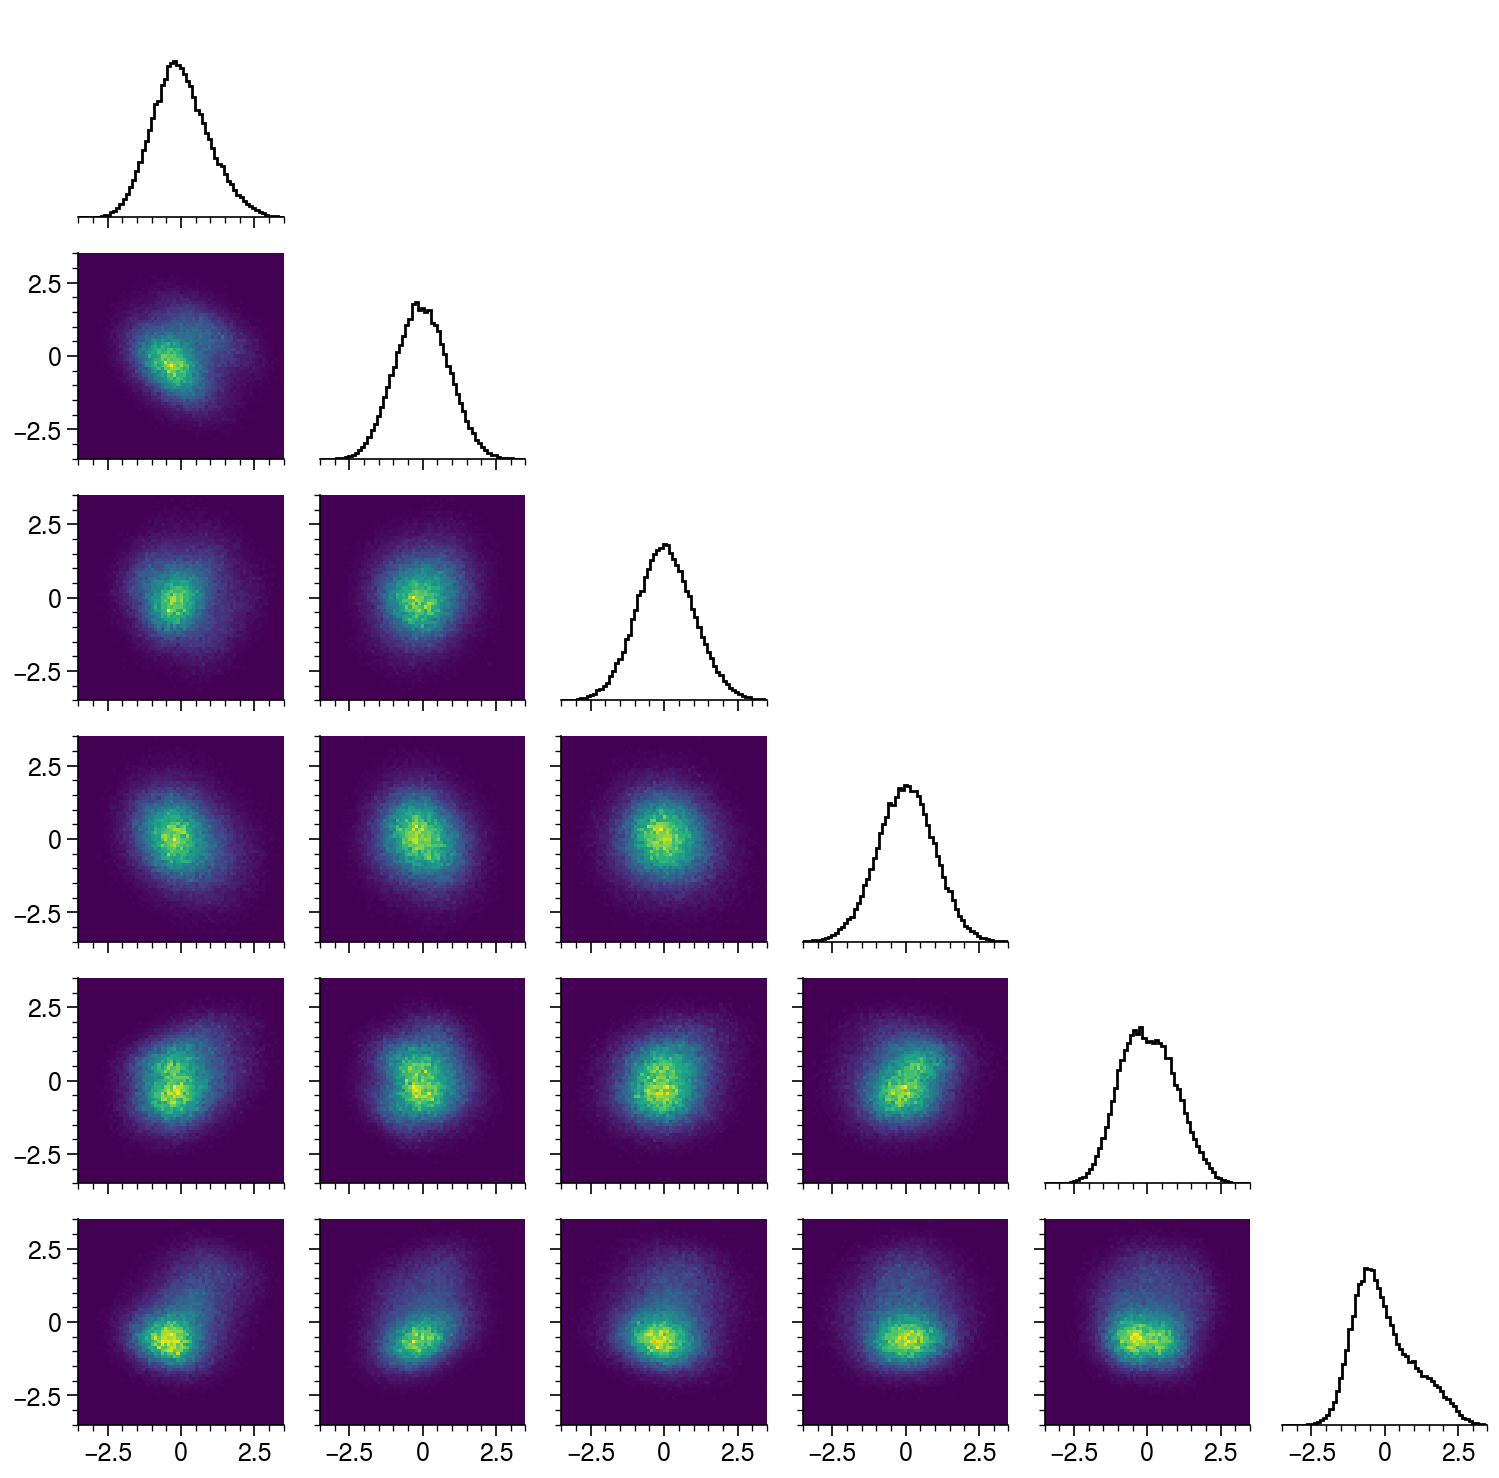

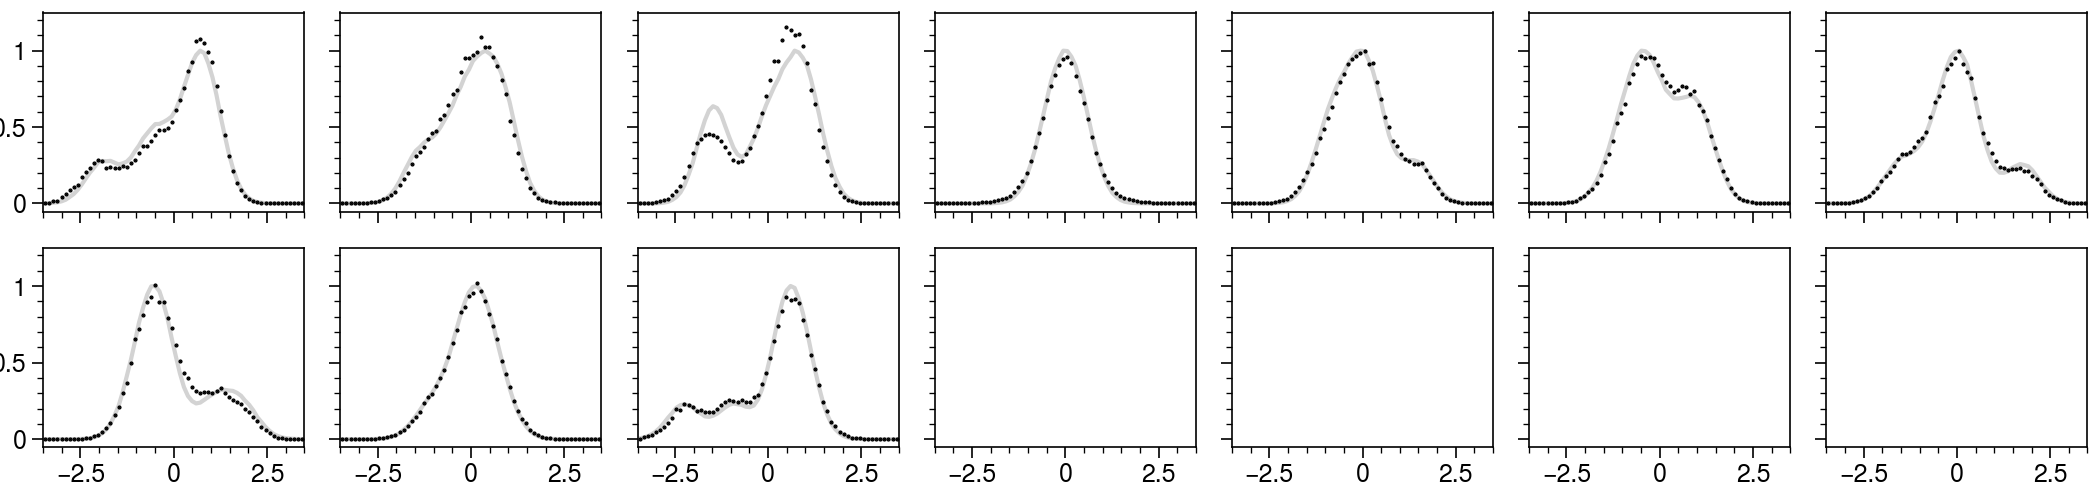

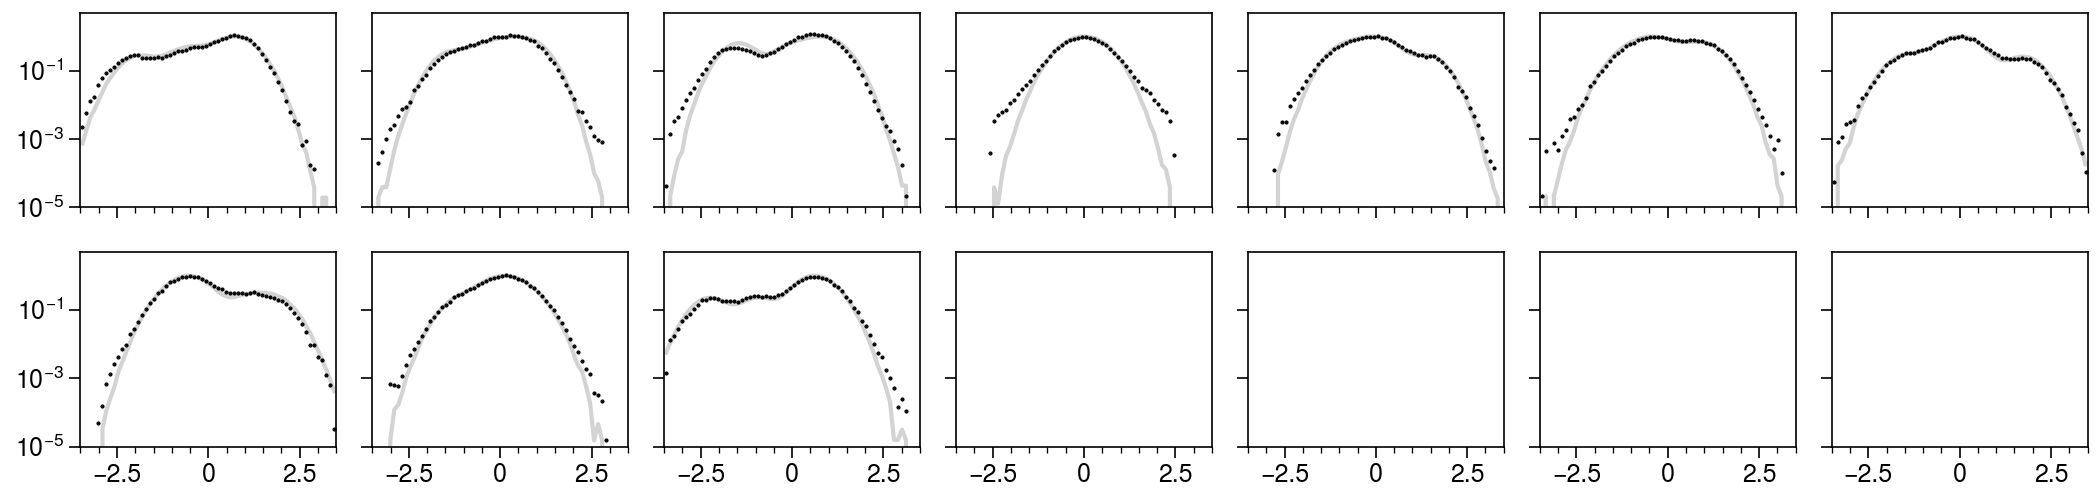

None
epoch = 2
transform=0
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███                                                                                                                                                | 250/12015 [00:00<00:04, 2499.48it/s]

  4%|██████                                                                                                                                             | 500/12015 [00:00<00:04, 2485.54it/s]

  6%|█████████▏                                                                                                                                         | 749/12015 [00:00<00:04, 2486.39it/s]

  8%|████████████▏                                                                                                                                      | 998/12015 [00:00<00:04, 2484.02it/s]

 10%|███████████████▏                                                                                                                                  | 1247/12015 [00:00<00:04, 2461.60it/s]

 12%|██████████████████▏                                                                                                                               | 1501/12015 [00:00<00:04, 2485.09it/s]

 15%|█████████████████████▎                                                                                                                            | 1759/12015 [00:00<00:04, 2513.37it/s]

 17%|████████████████████████▌                                                                                                                         | 2020/12015 [00:00<00:03, 2542.67it/s]

 19%|███████████████████████████▋                                                                                                                      | 2279/12015 [00:00<00:03, 2555.32it/s]

 21%|██████████████████████████████▊                                                                                                                   | 2538/12015 [00:01<00:03, 2563.66it/s]

 23%|██████████████████████████████████                                                                                                                | 2799/12015 [00:01<00:03, 2576.93it/s]

 26%|█████████████████████████████████████▏                                                                                                            | 3065/12015 [00:01<00:03, 2599.99it/s]

 28%|████████████████████████████████████████▍                                                                                                         | 3331/12015 [00:01<00:03, 2616.39it/s]

 30%|███████████████████████████████████████████▋                                                                                                      | 3596/12015 [00:01<00:03, 2626.02it/s]

 32%|██████████████████████████████████████████████▉                                                                                                   | 3859/12015 [00:01<00:03, 2619.08it/s]

 34%|██████████████████████████████████████████████████                                                                                                | 4121/12015 [00:01<00:03, 2618.66it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                            | 4383/12015 [00:01<00:02, 2610.04it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                         | 4648/12015 [00:01<00:02, 2619.73it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                      | 4910/12015 [00:01<00:02, 2614.75it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 5172/12015 [00:02<00:02, 2611.01it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                | 5434/12015 [00:02<00:02, 2600.34it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                            | 5700/12015 [00:02<00:02, 2617.43it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                         | 5962/12015 [00:02<00:02, 2614.28it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 6228/12015 [00:02<00:02, 2625.41it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                   | 6491/12015 [00:02<00:02, 2622.02it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                | 6754/12015 [00:02<00:02, 2612.13it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                            | 7016/12015 [00:02<00:01, 2611.32it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 7282/12015 [00:02<00:01, 2623.04it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 7545/12015 [00:02<00:01, 2616.82it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 7807/12015 [00:03<00:01, 2606.15it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                | 8071/12015 [00:03<00:01, 2614.20it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8337/12015 [00:03<00:01, 2626.94it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 8603/12015 [00:03<00:01, 2636.05it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 8867/12015 [00:03<00:01, 2632.63it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 9131/12015 [00:03<00:01, 2623.37it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 9394/12015 [00:03<00:01, 2607.38it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 9655/12015 [00:03<00:00, 2605.03it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 9919/12015 [00:03<00:00, 2613.18it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 10181/12015 [00:03<00:00, 2609.69it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 10442/12015 [00:04<00:00, 2597.57it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 10705/12015 [00:04<00:00, 2605.31it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 10972/12015 [00:04<00:00, 2622.36it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11238/12015 [00:04<00:00, 2631.09it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 11502/12015 [00:04<00:00, 2630.51it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 11766/12015 [00:04<00:00, 2625.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2597.45it/s]

transform=1
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 258/12015 [00:00<00:04, 2577.68it/s]

  4%|██████▎                                                                                                                                            | 520/12015 [00:00<00:04, 2599.88it/s]

  6%|█████████▌                                                                                                                                         | 780/12015 [00:00<00:04, 2598.84it/s]

  9%|████████████▋                                                                                                                                     | 1040/12015 [00:00<00:04, 2589.13it/s]

 11%|███████████████▊                                                                                                                                  | 1299/12015 [00:00<00:04, 2578.71it/s]

 13%|██████████████████▉                                                                                                                               | 1557/12015 [00:00<00:04, 2577.94it/s]

 15%|██████████████████████                                                                                                                            | 1815/12015 [00:00<00:03, 2577.56it/s]

 17%|█████████████████████████▏                                                                                                                        | 2073/12015 [00:00<00:03, 2567.67it/s]

 19%|████████████████████████████▎                                                                                                                     | 2330/12015 [00:00<00:03, 2566.64it/s]

 22%|███████████████████████████████▍                                                                                                                  | 2589/12015 [00:01<00:03, 2571.08it/s]

 24%|██████████████████████████████████▌                                                                                                               | 2847/12015 [00:01<00:03, 2571.99it/s]

 26%|█████████████████████████████████████▋                                                                                                            | 3105/12015 [00:01<00:03, 2573.00it/s]

 28%|████████████████████████████████████████▊                                                                                                         | 3363/12015 [00:01<00:03, 2574.72it/s]

 30%|████████████████████████████████████████████                                                                                                      | 3621/12015 [00:01<00:03, 2566.57it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 3878/12015 [00:01<00:03, 2563.41it/s]

 34%|██████████████████████████████████████████████████▎                                                                                               | 4137/12015 [00:01<00:03, 2568.90it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 4396/12015 [00:01<00:02, 2574.35it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                         | 4661/12015 [00:01<00:02, 2596.25it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                      | 4922/12015 [00:01<00:02, 2599.42it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                   | 5182/12015 [00:02<00:02, 2597.74it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                               | 5442/12015 [00:02<00:02, 2590.97it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                            | 5703/12015 [00:02<00:02, 2595.57it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                         | 5967/12015 [00:02<00:02, 2608.46it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 6228/12015 [00:02<00:02, 2599.38it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 6488/12015 [00:02<00:02, 2594.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                | 6753/12015 [00:02<00:02, 2610.99it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                            | 7015/12015 [00:02<00:01, 2612.79it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 7278/12015 [00:02<00:01, 2615.15it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 7543/12015 [00:02<00:01, 2623.91it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 7806/12015 [00:03<00:01, 2623.72it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                | 8069/12015 [00:03<00:01, 2599.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 8332/12015 [00:03<00:01, 2608.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 8593/12015 [00:03<00:01, 2607.38it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 8854/12015 [00:03<00:01, 2601.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 9115/12015 [00:03<00:01, 2599.01it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 9380/12015 [00:03<00:01, 2613.18it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 9642/12015 [00:03<00:00, 2612.68it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 9907/12015 [00:03<00:00, 2623.63it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 10174/12015 [00:03<00:00, 2634.81it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 10438/12015 [00:04<00:00, 2635.28it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 10702/12015 [00:04<00:00, 2609.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 10964/12015 [00:04<00:00, 2586.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 11223/12015 [00:04<00:00, 2586.23it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 11482/12015 [00:04<00:00, 2583.05it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 11741/12015 [00:04<00:00, 2581.61it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 12004/12015 [00:04<00:00, 2595.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2594.58it/s]

transform=2
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 259/12015 [00:00<00:04, 2581.79it/s]

  4%|██████▎                                                                                                                                            | 519/12015 [00:00<00:04, 2591.09it/s]

  7%|█████████▌                                                                                                                                         | 784/12015 [00:00<00:04, 2613.79it/s]

  9%|████████████▋                                                                                                                                     | 1046/12015 [00:00<00:04, 2600.30it/s]

 11%|███████████████▉                                                                                                                                  | 1307/12015 [00:00<00:04, 2593.30it/s]

 13%|███████████████████                                                                                                                               | 1567/12015 [00:00<00:04, 2589.04it/s]

 15%|██████████████████████▏                                                                                                                           | 1826/12015 [00:00<00:03, 2584.44it/s]

 17%|█████████████████████████▎                                                                                                                        | 2087/12015 [00:00<00:03, 2590.37it/s]

 20%|████████████████████████████▌                                                                                                                     | 2347/12015 [00:00<00:03, 2587.46it/s]

 22%|███████████████████████████████▋                                                                                                                  | 2608/12015 [00:01<00:03, 2591.50it/s]

 24%|██████████████████████████████████▊                                                                                                               | 2868/12015 [00:01<00:03, 2590.08it/s]

 26%|██████████████████████████████████████                                                                                                            | 3128/12015 [00:01<00:03, 2585.08it/s]

 28%|█████████████████████████████████████████▏                                                                                                        | 3389/12015 [00:01<00:03, 2590.54it/s]

 30%|████████████████████████████████████████████▎                                                                                                     | 3649/12015 [00:01<00:03, 2572.89it/s]

 33%|███████████████████████████████████████████████▍                                                                                                  | 3907/12015 [00:01<00:03, 2543.47it/s]

 35%|██████████████████████████████████████████████████▌                                                                                               | 4162/12015 [00:01<00:03, 2536.36it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                            | 4416/12015 [00:01<00:03, 2525.09it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                         | 4669/12015 [00:01<00:02, 2525.44it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                      | 4924/12015 [00:01<00:02, 2530.06it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                   | 5179/12015 [00:02<00:02, 2534.65it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                | 5433/12015 [00:02<00:02, 2531.85it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                             | 5687/12015 [00:02<00:02, 2519.16it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                         | 5939/12015 [00:02<00:02, 2506.74it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 6191/12015 [00:02<00:02, 2508.39it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 6443/12015 [00:02<00:02, 2510.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                                | 6695/12015 [00:02<00:02, 2507.08it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 6946/12015 [00:02<00:02, 2503.45it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▍                                                          | 7197/12015 [00:02<00:01, 2494.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 7447/12015 [00:02<00:01, 2478.19it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 7697/12015 [00:03<00:01, 2483.65it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 7946/12015 [00:03<00:01, 2479.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 8202/12015 [00:03<00:01, 2500.63it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 8457/12015 [00:03<00:01, 2514.31it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 8710/12015 [00:03<00:01, 2517.26it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 8962/12015 [00:03<00:01, 2511.10it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 9214/12015 [00:03<00:01, 2510.07it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 9466/12015 [00:03<00:01, 2488.20it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 9715/12015 [00:03<00:00, 2484.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 9964/12015 [00:03<00:00, 2481.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 10213/12015 [00:04<00:00, 2476.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 10461/12015 [00:04<00:00, 2476.15it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 10710/12015 [00:04<00:00, 2478.64it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 10962/12015 [00:04<00:00, 2490.70it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 11215/12015 [00:04<00:00, 2500.28it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 11468/12015 [00:04<00:00, 2508.56it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 11722/12015 [00:04<00:00, 2515.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 11974/12015 [00:04<00:00, 2515.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2526.59it/s]

transform=3
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███                                                                                                                                                | 252/12015 [00:00<00:04, 2518.59it/s]

  4%|██████▏                                                                                                                                            | 504/12015 [00:00<00:04, 2513.56it/s]

  6%|█████████▏                                                                                                                                         | 756/12015 [00:00<00:04, 2512.42it/s]

  8%|████████████▏                                                                                                                                     | 1008/12015 [00:00<00:04, 2506.39it/s]

 10%|███████████████▎                                                                                                                                  | 1261/12015 [00:00<00:04, 2511.36it/s]

 13%|██████████████████▍                                                                                                                               | 1513/12015 [00:00<00:04, 2512.54it/s]

 15%|█████████████████████▍                                                                                                                            | 1765/12015 [00:00<00:04, 2512.17it/s]

 17%|████████████████████████▌                                                                                                                         | 2017/12015 [00:00<00:03, 2514.31it/s]

 19%|███████████████████████████▌                                                                                                                      | 2269/12015 [00:00<00:03, 2514.58it/s]

 21%|██████████████████████████████▋                                                                                                                   | 2521/12015 [00:01<00:03, 2511.24it/s]

 23%|█████████████████████████████████▋                                                                                                                | 2773/12015 [00:01<00:03, 2490.25it/s]

 25%|████████████████████████████████████▊                                                                                                             | 3032/12015 [00:01<00:03, 2517.97it/s]

 27%|███████████████████████████████████████▉                                                                                                          | 3284/12015 [00:01<00:03, 2491.61it/s]

 29%|███████████████████████████████████████████                                                                                                       | 3544/12015 [00:01<00:03, 2522.15it/s]

 32%|██████████████████████████████████████████████▎                                                                                                   | 3808/12015 [00:01<00:03, 2557.21it/s]

 34%|█████████████████████████████████████████████████▍                                                                                                | 4072/12015 [00:01<00:03, 2581.45it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 4338/12015 [00:01<00:02, 2602.12it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                          | 4603/12015 [00:01<00:02, 2614.39it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                      | 4866/12015 [00:01<00:02, 2616.40it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                   | 5128/12015 [00:02<00:02, 2617.44it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                | 5391/12015 [00:02<00:02, 2620.67it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                             | 5657/12015 [00:02<00:02, 2631.52it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                          | 5921/12015 [00:02<00:02, 2632.05it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 6185/12015 [00:02<00:02, 2628.19it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                   | 6451/12015 [00:02<00:02, 2636.51it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                | 6716/12015 [00:02<00:02, 2640.25it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                             | 6981/12015 [00:02<00:01, 2640.94it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                          | 7246/12015 [00:02<00:01, 2598.14it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 7506/12015 [00:02<00:01, 2551.00it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 7762/12015 [00:03<00:01, 2517.45it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 8014/12015 [00:03<00:01, 2493.96it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 8264/12015 [00:03<00:01, 2488.97it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 8513/12015 [00:03<00:01, 2483.46it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 8762/12015 [00:03<00:01, 2476.65it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 9010/12015 [00:03<00:01, 2467.19it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 9257/12015 [00:03<00:01, 2464.77it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 9506/12015 [00:03<00:01, 2469.73it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 9756/12015 [00:03<00:00, 2477.73it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 10012/12015 [00:03<00:00, 2500.73it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 10263/12015 [00:04<00:00, 2498.88it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 10513/12015 [00:04<00:00, 2495.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 10764/12015 [00:04<00:00, 2498.90it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 11015/12015 [00:04<00:00, 2502.10it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 11266/12015 [00:04<00:00, 2503.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 11517/12015 [00:04<00:00, 2503.00it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 11768/12015 [00:04<00:00, 2503.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2535.18it/s]

transform=4
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███                                                                                                                                                | 253/12015 [00:00<00:04, 2528.91it/s]

  4%|██████▏                                                                                                                                            | 506/12015 [00:00<00:04, 2514.80it/s]

  6%|█████████▎                                                                                                                                         | 758/12015 [00:00<00:04, 2511.09it/s]

  8%|████████████▎                                                                                                                                     | 1010/12015 [00:00<00:04, 2493.22it/s]

 10%|███████████████▎                                                                                                                                  | 1260/12015 [00:00<00:04, 2489.19it/s]

 13%|██████████████████▎                                                                                                                               | 1509/12015 [00:00<00:04, 2488.68it/s]

 15%|█████████████████████▍                                                                                                                            | 1764/12015 [00:00<00:04, 2506.89it/s]

 17%|████████████████████████▌                                                                                                                         | 2019/12015 [00:00<00:03, 2518.19it/s]

 19%|███████████████████████████▌                                                                                                                      | 2272/12015 [00:00<00:03, 2520.61it/s]

 21%|██████████████████████████████▋                                                                                                                   | 2525/12015 [00:01<00:03, 2521.21it/s]

 23%|█████████████████████████████████▊                                                                                                                | 2779/12015 [00:01<00:03, 2525.82it/s]

 25%|████████████████████████████████████▊                                                                                                             | 3032/12015 [00:01<00:03, 2524.26it/s]

 27%|███████████████████████████████████████▉                                                                                                          | 3285/12015 [00:01<00:03, 2524.30it/s]

 29%|███████████████████████████████████████████                                                                                                       | 3539/12015 [00:01<00:03, 2528.20it/s]

 32%|██████████████████████████████████████████████                                                                                                    | 3792/12015 [00:01<00:03, 2523.69it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 4045/12015 [00:01<00:03, 2522.00it/s]

 36%|████████████████████████████████████████████████████▏                                                                                             | 4298/12015 [00:01<00:03, 2520.90it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                          | 4551/12015 [00:01<00:02, 2522.82it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 4804/12015 [00:01<00:02, 2523.54it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                    | 5058/12015 [00:02<00:02, 2526.20it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 5313/12015 [00:02<00:02, 2530.79it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                              | 5567/12015 [00:02<00:02, 2530.22it/s]

 48%|██████████████████████████████████████████████████████████████████████▋                                                                           | 5821/12015 [00:02<00:02, 2509.33it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                        | 6073/12015 [00:02<00:02, 2511.67it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                     | 6327/12015 [00:02<00:02, 2517.63it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                  | 6580/12015 [00:02<00:02, 2520.30it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                               | 6833/12015 [00:02<00:02, 2522.47it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                            | 7086/12015 [00:02<00:01, 2516.24it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 7340/12015 [00:02<00:01, 2521.44it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 7595/12015 [00:03<00:01, 2526.97it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 7849/12015 [00:03<00:01, 2530.72it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 8104/12015 [00:03<00:01, 2536.07it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 8358/12015 [00:03<00:01, 2533.47it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 8612/12015 [00:03<00:01, 2535.26it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 8866/12015 [00:03<00:01, 2529.09it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 9119/12015 [00:03<00:01, 2527.64it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 9373/12015 [00:03<00:01, 2529.63it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 9626/12015 [00:03<00:00, 2519.48it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 9878/12015 [00:03<00:00, 2508.92it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 10129/12015 [00:04<00:00, 2497.03it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 10379/12015 [00:04<00:00, 2493.06it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 10631/12015 [00:04<00:00, 2499.62it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 10881/12015 [00:04<00:00, 2494.95it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 11131/12015 [00:04<00:00, 2491.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 11381/12015 [00:04<00:00, 2482.70it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 11633/12015 [00:04<00:00, 2493.08it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 11883/12015 [00:04<00:00, 2492.61it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2513.64it/s]

transform=5
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|██▉                                                                                                                                                | 243/12015 [00:00<00:04, 2424.62it/s]

  4%|██████                                                                                                                                             | 494/12015 [00:00<00:04, 2470.40it/s]

  6%|█████████                                                                                                                                          | 745/12015 [00:00<00:04, 2484.68it/s]

  8%|████████████▏                                                                                                                                      | 995/12015 [00:00<00:04, 2487.83it/s]

 10%|███████████████                                                                                                                                   | 1244/12015 [00:00<00:04, 2484.83it/s]

 12%|██████████████████▏                                                                                                                               | 1501/12015 [00:00<00:04, 2512.93it/s]

 15%|█████████████████████▍                                                                                                                            | 1760/12015 [00:00<00:04, 2535.04it/s]

 17%|████████████████████████▌                                                                                                                         | 2025/12015 [00:00<00:03, 2568.54it/s]

 19%|███████████████████████████▊                                                                                                                      | 2287/12015 [00:00<00:03, 2582.39it/s]

 21%|██████████████████████████████▉                                                                                                                   | 2546/12015 [00:01<00:03, 2584.63it/s]

 23%|██████████████████████████████████▏                                                                                                               | 2810/12015 [00:01<00:03, 2600.86it/s]

 26%|█████████████████████████████████████▎                                                                                                            | 3075/12015 [00:01<00:03, 2615.61it/s]

 28%|████████████████████████████████████████▌                                                                                                         | 3342/12015 [00:01<00:03, 2629.69it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 3605/12015 [00:01<00:03, 2627.36it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 3868/12015 [00:01<00:03, 2611.16it/s]

 34%|██████████████████████████████████████████████████▏                                                                                               | 4130/12015 [00:01<00:03, 2600.12it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                            | 4391/12015 [00:01<00:02, 2596.76it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                         | 4651/12015 [00:01<00:02, 2595.98it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                      | 4911/12015 [00:01<00:02, 2593.64it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 5171/12015 [00:02<00:02, 2592.85it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                | 5431/12015 [00:02<00:02, 2588.45it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                            | 5690/12015 [00:02<00:02, 2587.76it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                         | 5949/12015 [00:02<00:02, 2586.87it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                      | 6210/12015 [00:02<00:02, 2592.98it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▌                                                                   | 6470/12015 [00:02<00:02, 2592.12it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 6730/12015 [00:02<00:02, 2577.25it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                             | 6989/12015 [00:02<00:01, 2580.74it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                          | 7248/12015 [00:02<00:01, 2577.47it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 7506/12015 [00:02<00:01, 2576.16it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 7765/12015 [00:03<00:01, 2579.64it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 8025/12015 [00:03<00:01, 2585.04it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 8285/12015 [00:03<00:01, 2588.19it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 8544/12015 [00:03<00:01, 2548.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 8799/12015 [00:03<00:01, 2536.65it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 9053/12015 [00:03<00:01, 2536.60it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 9307/12015 [00:03<00:01, 2535.48it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 9565/12015 [00:03<00:00, 2548.57it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 9827/12015 [00:03<00:00, 2569.16it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 10090/12015 [00:03<00:00, 2586.29it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 10353/12015 [00:04<00:00, 2596.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 10613/12015 [00:04<00:00, 2597.32it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 10873/12015 [00:04<00:00, 2596.01it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 11137/12015 [00:04<00:00, 2607.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 11400/12015 [00:04<00:00, 2613.60it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 11662/12015 [00:04<00:00, 2582.27it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 11922/12015 [00:04<00:00, 2585.46it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2576.29it/s]

transform=6
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 257/12015 [00:00<00:04, 2566.15it/s]

  4%|██████▎                                                                                                                                            | 515/12015 [00:00<00:04, 2571.80it/s]

  6%|█████████▌                                                                                                                                         | 778/12015 [00:00<00:04, 2597.69it/s]

  9%|████████████▌                                                                                                                                     | 1038/12015 [00:00<00:04, 2566.45it/s]

 11%|███████████████▋                                                                                                                                  | 1295/12015 [00:00<00:04, 2567.09it/s]

 13%|██████████████████▊                                                                                                                               | 1552/12015 [00:00<00:04, 2565.15it/s]

 15%|█████████████████████▉                                                                                                                            | 1810/12015 [00:00<00:03, 2567.12it/s]

 17%|█████████████████████████                                                                                                                         | 2067/12015 [00:00<00:03, 2562.34it/s]

 19%|████████████████████████████▏                                                                                                                     | 2324/12015 [00:00<00:03, 2543.52it/s]

 22%|███████████████████████████████▍                                                                                                                  | 2584/12015 [00:01<00:03, 2559.55it/s]

 24%|██████████████████████████████████▌                                                                                                               | 2846/12015 [00:01<00:03, 2577.25it/s]

 26%|█████████████████████████████████████▊                                                                                                            | 3107/12015 [00:01<00:03, 2586.59it/s]

 28%|████████████████████████████████████████▉                                                                                                         | 3372/12015 [00:01<00:03, 2605.07it/s]

 30%|████████████████████████████████████████████▏                                                                                                     | 3633/12015 [00:01<00:03, 2593.68it/s]

 32%|███████████████████████████████████████████████▎                                                                                                  | 3894/12015 [00:01<00:03, 2597.27it/s]

 35%|██████████████████████████████████████████████████▍                                                                                               | 4154/12015 [00:01<00:03, 2596.95it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                            | 4414/12015 [00:01<00:02, 2595.56it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                         | 4677/12015 [00:01<00:02, 2605.74it/s]

 41%|████████████████████████████████████████████████████████████                                                                                      | 4938/12015 [00:01<00:02, 2604.16it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                  | 5199/12015 [00:02<00:02, 2596.31it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                               | 5459/12015 [00:02<00:02, 2595.61it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                            | 5722/12015 [00:02<00:02, 2604.84it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                         | 5983/12015 [00:02<00:02, 2604.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 6246/12015 [00:02<00:02, 2610.62it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                   | 6508/12015 [00:02<00:02, 2577.65it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                               | 6766/12015 [00:02<00:02, 2542.52it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                            | 7024/12015 [00:02<00:01, 2550.96it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 7284/12015 [00:02<00:01, 2564.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 7544/12015 [00:02<00:01, 2574.38it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 7802/12015 [00:03<00:01, 2574.10it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 8060/12015 [00:03<00:01, 2573.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 8320/12015 [00:03<00:01, 2581.61it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 8579/12015 [00:03<00:01, 2581.80it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 8838/12015 [00:03<00:01, 2578.09it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 9096/12015 [00:03<00:01, 2573.90it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 9356/12015 [00:03<00:01, 2580.25it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 9615/12015 [00:03<00:00, 2572.07it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 9876/12015 [00:03<00:00, 2582.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 10137/12015 [00:03<00:00, 2590.25it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 10400/12015 [00:04<00:00, 2601.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 10663/12015 [00:04<00:00, 2607.30it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 10924/12015 [00:04<00:00, 2564.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 11181/12015 [00:04<00:00, 2519.12it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 11434/12015 [00:04<00:00, 2521.92it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 11687/12015 [00:04<00:00, 2517.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 11939/12015 [00:04<00:00, 2517.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2571.02it/s]

transform=7
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|██▊                                                                                                                                                | 230/12015 [00:00<00:05, 2293.83it/s]

  4%|█████▋                                                                                                                                             | 466/12015 [00:00<00:04, 2329.38it/s]

  6%|████████▌                                                                                                                                          | 701/12015 [00:00<00:04, 2335.18it/s]

  8%|███████████▌                                                                                                                                       | 944/12015 [00:00<00:04, 2372.36it/s]

 10%|██████████████▍                                                                                                                                   | 1183/12015 [00:00<00:04, 2377.39it/s]

 12%|█████████████████▍                                                                                                                                | 1433/12015 [00:00<00:04, 2418.87it/s]

 14%|████████████████████▍                                                                                                                             | 1686/12015 [00:00<00:04, 2452.50it/s]

 16%|███████████████████████▍                                                                                                                          | 1932/12015 [00:00<00:04, 2410.50it/s]

 18%|██████████████████████████▍                                                                                                                       | 2174/12015 [00:00<00:04, 2352.36it/s]

 20%|█████████████████████████████▎                                                                                                                    | 2410/12015 [00:01<00:04, 2352.00it/s]

 22%|████████████████████████████████▏                                                                                                                 | 2646/12015 [00:01<00:04, 2338.68it/s]

 24%|███████████████████████████████████                                                                                                               | 2881/12015 [00:01<00:03, 2323.34it/s]

 26%|█████████████████████████████████████▊                                                                                                            | 3114/12015 [00:01<00:03, 2323.92it/s]

 28%|████████████████████████████████████████▋                                                                                                         | 3349/12015 [00:01<00:03, 2331.05it/s]

 30%|███████████████████████████████████████████▌                                                                                                      | 3583/12015 [00:01<00:03, 2319.61it/s]

 32%|██████████████████████████████████████████████▍                                                                                                   | 3824/12015 [00:01<00:03, 2345.83it/s]

 34%|█████████████████████████████████████████████████▎                                                                                                | 4062/12015 [00:01<00:03, 2355.07it/s]

 36%|████████████████████████████████████████████████████▏                                                                                             | 4299/12015 [00:01<00:03, 2359.03it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                          | 4552/12015 [00:01<00:03, 2408.58it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 4806/12015 [00:02<00:02, 2446.57it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                    | 5067/12015 [00:02<00:02, 2494.77it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                 | 5327/12015 [00:02<00:02, 2525.36it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                              | 5588/12015 [00:02<00:02, 2547.84it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                           | 5848/12015 [00:02<00:02, 2561.20it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                       | 6108/12015 [00:02<00:02, 2571.77it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                    | 6367/12015 [00:02<00:02, 2576.19it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 6628/12015 [00:02<00:02, 2586.03it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                              | 6888/12015 [00:02<00:01, 2588.24it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                           | 7147/12015 [00:02<00:01, 2587.99it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████                                                        | 7407/12015 [00:03<00:01, 2589.18it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 7673/12015 [00:03<00:01, 2608.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 7934/12015 [00:03<00:01, 2604.27it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 8195/12015 [00:03<00:01, 2599.09it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 8455/12015 [00:03<00:01, 2593.79it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 8715/12015 [00:03<00:01, 2585.93it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 8979/12015 [00:03<00:01, 2601.24it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 9242/12015 [00:03<00:01, 2607.45it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 9503/12015 [00:03<00:00, 2602.04it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 9764/12015 [00:03<00:00, 2598.38it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 10024/12015 [00:04<00:00, 2581.76it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 10283/12015 [00:04<00:00, 2579.97it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 10542/12015 [00:04<00:00, 2575.14it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 10800/12015 [00:04<00:00, 2571.97it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 11058/12015 [00:04<00:00, 2574.29it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 11316/12015 [00:04<00:00, 2575.02it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 11577/12015 [00:04<00:00, 2582.60it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 11840/12015 [00:04<00:00, 2594.15it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2500.80it/s]

transform=8
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 258/12015 [00:00<00:04, 2575.62it/s]

  4%|██████▎                                                                                                                                            | 517/12015 [00:00<00:04, 2583.91it/s]

  6%|█████████▌                                                                                                                                         | 777/12015 [00:00<00:04, 2587.07it/s]

  9%|████████████▌                                                                                                                                     | 1036/12015 [00:00<00:04, 2586.12it/s]

 11%|███████████████▋                                                                                                                                  | 1295/12015 [00:00<00:04, 2585.81it/s]

 13%|██████████████████▉                                                                                                                               | 1555/12015 [00:00<00:04, 2588.69it/s]

 15%|██████████████████████                                                                                                                            | 1814/12015 [00:00<00:03, 2586.78it/s]

 17%|█████████████████████████▏                                                                                                                        | 2073/12015 [00:00<00:03, 2587.74it/s]

 19%|████████████████████████████▎                                                                                                                     | 2334/12015 [00:00<00:03, 2593.25it/s]

 22%|███████████████████████████████▌                                                                                                                  | 2594/12015 [00:01<00:03, 2588.71it/s]

 24%|██████████████████████████████████▋                                                                                                               | 2853/12015 [00:01<00:03, 2582.94it/s]

 26%|█████████████████████████████████████▊                                                                                                            | 3113/12015 [00:01<00:03, 2585.56it/s]

 28%|████████████████████████████████████████▉                                                                                                         | 3372/12015 [00:01<00:03, 2582.25it/s]

 30%|████████████████████████████████████████████                                                                                                      | 3631/12015 [00:01<00:03, 2583.54it/s]

 32%|███████████████████████████████████████████████▎                                                                                                  | 3891/12015 [00:01<00:03, 2586.41it/s]

 35%|██████████████████████████████████████████████████▍                                                                                               | 4150/12015 [00:01<00:03, 2582.21it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                            | 4410/12015 [00:01<00:02, 2585.76it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                         | 4669/12015 [00:01<00:02, 2584.18it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                      | 4932/12015 [00:01<00:02, 2595.60it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                   | 5192/12015 [00:02<00:02, 2595.22it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                               | 5452/12015 [00:02<00:02, 2594.26it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 5713/12015 [00:02<00:02, 2596.99it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                         | 5975/12015 [00:02<00:02, 2600.21it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                      | 6236/12015 [00:02<00:02, 2560.27it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                   | 6493/12015 [00:02<00:02, 2553.48it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                | 6749/12015 [00:02<00:02, 2549.40it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                            | 7010/12015 [00:02<00:01, 2566.39it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 7271/12015 [00:02<00:01, 2577.04it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 7530/12015 [00:02<00:01, 2579.12it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 7794/12015 [00:03<00:01, 2595.24it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 8057/12015 [00:03<00:01, 2604.24it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 8318/12015 [00:03<00:01, 2605.19it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 8579/12015 [00:03<00:01, 2545.43it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 8834/12015 [00:03<00:01, 2514.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 9086/12015 [00:03<00:01, 2502.78it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 9344/12015 [00:03<00:01, 2523.93it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 9609/12015 [00:03<00:00, 2560.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 9875/12015 [00:03<00:00, 2589.28it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 10139/12015 [00:03<00:00, 2603.20it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 10402/12015 [00:04<00:00, 2610.51it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 10664/12015 [00:04<00:00, 2612.46it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 10928/12015 [00:04<00:00, 2619.70it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 11191/12015 [00:04<00:00, 2618.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 11453/12015 [00:04<00:00, 2613.94it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 11715/12015 [00:04<00:00, 2610.58it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 11980/12015 [00:04<00:00, 2621.27it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2585.36it/s]

transform=9
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 260/12015 [00:00<00:04, 2590.98it/s]

  4%|██████▍                                                                                                                                            | 524/12015 [00:00<00:04, 2619.55it/s]

  7%|█████████▋                                                                                                                                         | 788/12015 [00:00<00:04, 2626.54it/s]

  9%|████████████▊                                                                                                                                     | 1054/12015 [00:00<00:04, 2636.08it/s]

 11%|████████████████                                                                                                                                  | 1318/12015 [00:00<00:04, 2628.14it/s]

 13%|███████████████████▎                                                                                                                              | 1585/12015 [00:00<00:03, 2640.44it/s]

 15%|██████████████████████▍                                                                                                                           | 1850/12015 [00:00<00:03, 2640.55it/s]

 18%|█████████████████████████▋                                                                                                                        | 2116/12015 [00:00<00:03, 2644.25it/s]

 20%|████████████████████████████▉                                                                                                                     | 2383/12015 [00:00<00:03, 2650.89it/s]

 22%|████████████████████████████████▏                                                                                                                 | 2650/12015 [00:01<00:03, 2653.78it/s]

 24%|███████████████████████████████████▍                                                                                                              | 2917/12015 [00:01<00:03, 2657.00it/s]

 26%|██████████████████████████████████████▋                                                                                                           | 3183/12015 [00:01<00:03, 2651.84it/s]

 29%|█████████████████████████████████████████▉                                                                                                        | 3449/12015 [00:01<00:03, 2650.29it/s]

 31%|█████████████████████████████████████████████▏                                                                                                    | 3716/12015 [00:01<00:03, 2655.37it/s]

 33%|████████████████████████████████████████████████▍                                                                                                 | 3982/12015 [00:01<00:03, 2656.59it/s]

 35%|███████████████████████████████████████████████████▌                                                                                              | 4248/12015 [00:01<00:02, 2640.95it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                           | 4513/12015 [00:01<00:02, 2634.18it/s]

 40%|██████████████████████████████████████████████████████████                                                                                        | 4777/12015 [00:01<00:02, 2634.54it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                    | 5042/12015 [00:01<00:02, 2637.30it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                 | 5307/12015 [00:02<00:02, 2638.58it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                              | 5571/12015 [00:02<00:02, 2636.80it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                           | 5836/12015 [00:02<00:02, 2639.40it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                        | 6100/12015 [00:02<00:02, 2633.52it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                    | 6365/12015 [00:02<00:02, 2637.77it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 6630/12015 [00:02<00:02, 2639.58it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                              | 6896/12015 [00:02<00:01, 2643.74it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                           | 7163/12015 [00:02<00:01, 2650.45it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 7429/12015 [00:02<00:01, 2648.60it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 7695/12015 [00:02<00:01, 2650.84it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 7961/12015 [00:03<00:01, 2638.30it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 8225/12015 [00:03<00:01, 2624.11it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 8488/12015 [00:03<00:01, 2614.48it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 8753/12015 [00:03<00:01, 2622.84it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 9016/12015 [00:03<00:01, 2621.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 9280/12015 [00:03<00:01, 2626.41it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 9546/12015 [00:03<00:00, 2634.46it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 9810/12015 [00:03<00:00, 2632.73it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 10074/12015 [00:03<00:00, 2616.34it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 10337/12015 [00:03<00:00, 2619.93it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 10603/12015 [00:04<00:00, 2631.34it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 10869/12015 [00:04<00:00, 2637.63it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 11136/12015 [00:04<00:00, 2645.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 11401/12015 [00:04<00:00, 2615.20it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 11663/12015 [00:04<00:00, 2587.27it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 11922/12015 [00:04<00:00, 2587.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2632.00it/s]

  0%|                                                                                                                                                               | 0/14031 [00:00<?, ?it/s]

  2%|██▋                                                                                                                                                | 259/14031 [00:00<00:05, 2583.93it/s]

  4%|█████▍                                                                                                                                             | 520/14031 [00:00<00:05, 2595.07it/s]

  6%|████████▏                                                                                                                                          | 783/14031 [00:00<00:05, 2608.73it/s]

  7%|██████████▊                                                                                                                                       | 1045/14031 [00:00<00:04, 2611.79it/s]

  9%|█████████████▌                                                                                                                                    | 1309/14031 [00:00<00:04, 2619.52it/s]

 11%|████████████████▎                                                                                                                                 | 1573/14031 [00:00<00:04, 2624.41it/s]

 13%|███████████████████▏                                                                                                                              | 1838/14031 [00:00<00:04, 2631.73it/s]

 15%|█████████████████████▊                                                                                                                            | 2102/14031 [00:00<00:04, 2627.14it/s]

 17%|████████████████████████▌                                                                                                                         | 2365/14031 [00:00<00:04, 2621.64it/s]

 19%|███████████████████████████▎                                                                                                                      | 2629/14031 [00:01<00:04, 2625.04it/s]

 21%|██████████████████████████████                                                                                                                    | 2892/14031 [00:01<00:04, 2625.23it/s]

 22%|████████████████████████████████▊                                                                                                                 | 3156/14031 [00:01<00:04, 2629.29it/s]

 24%|███████████████████████████████████▌                                                                                                              | 3419/14031 [00:01<00:04, 2628.16it/s]

 26%|██████████████████████████████████████▎                                                                                                           | 3684/14031 [00:01<00:03, 2634.60it/s]

 28%|█████████████████████████████████████████                                                                                                         | 3948/14031 [00:01<00:03, 2629.73it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 4211/14031 [00:01<00:03, 2627.56it/s]

 32%|██████████████████████████████████████████████▌                                                                                                   | 4474/14031 [00:01<00:03, 2626.03it/s]

 34%|█████████████████████████████████████████████████▎                                                                                                | 4737/14031 [00:01<00:03, 2614.95it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 4999/14031 [00:01<00:03, 2611.09it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                           | 5261/14031 [00:02<00:03, 2591.15it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                        | 5521/14031 [00:02<00:03, 2580.96it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                     | 5780/14031 [00:02<00:03, 2573.67it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 6041/14031 [00:02<00:03, 2583.10it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                | 6305/14031 [00:02<00:02, 2599.23it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                             | 6569/14031 [00:02<00:02, 2608.52it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                           | 6834/14031 [00:02<00:02, 2619.39it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 7101/14031 [00:02<00:02, 2631.60it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 7366/14031 [00:02<00:02, 2636.04it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                  | 7630/14031 [00:02<00:02, 2599.97it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                | 7891/14031 [00:03<00:02, 2602.21it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                             | 8153/14031 [00:03<00:02, 2604.99it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 8416/14031 [00:03<00:02, 2611.36it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 8678/14031 [00:03<00:02, 2613.57it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████                                                     | 8940/14031 [00:03<00:01, 2608.90it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 9203/14031 [00:03<00:01, 2615.16it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 9466/14031 [00:03<00:01, 2617.74it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 9732/14031 [00:03<00:01, 2629.53it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 9996/14031 [00:03<00:01, 2631.94it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 10261/14031 [00:03<00:01, 2636.16it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 10527/14031 [00:04<00:01, 2640.85it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 10793/14031 [00:04<00:01, 2644.62it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 11059/14031 [00:04<00:01, 2647.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 11325/14031 [00:04<00:01, 2648.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 11590/14031 [00:04<00:00, 2645.15it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 11855/14031 [00:04<00:00, 2642.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 12121/14031 [00:04<00:00, 2646.75it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 12387/14031 [00:04<00:00, 2649.48it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 12653/14031 [00:04<00:00, 2651.74it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 12920/14031 [00:04<00:00, 2654.27it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 13186/14031 [00:05<00:00, 2642.95it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 13451/14031 [00:05<00:00, 2644.96it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 13718/14031 [00:05<00:00, 2649.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 13984/14031 [00:05<00:00, 2651.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:05<00:00, 2625.15it/s]

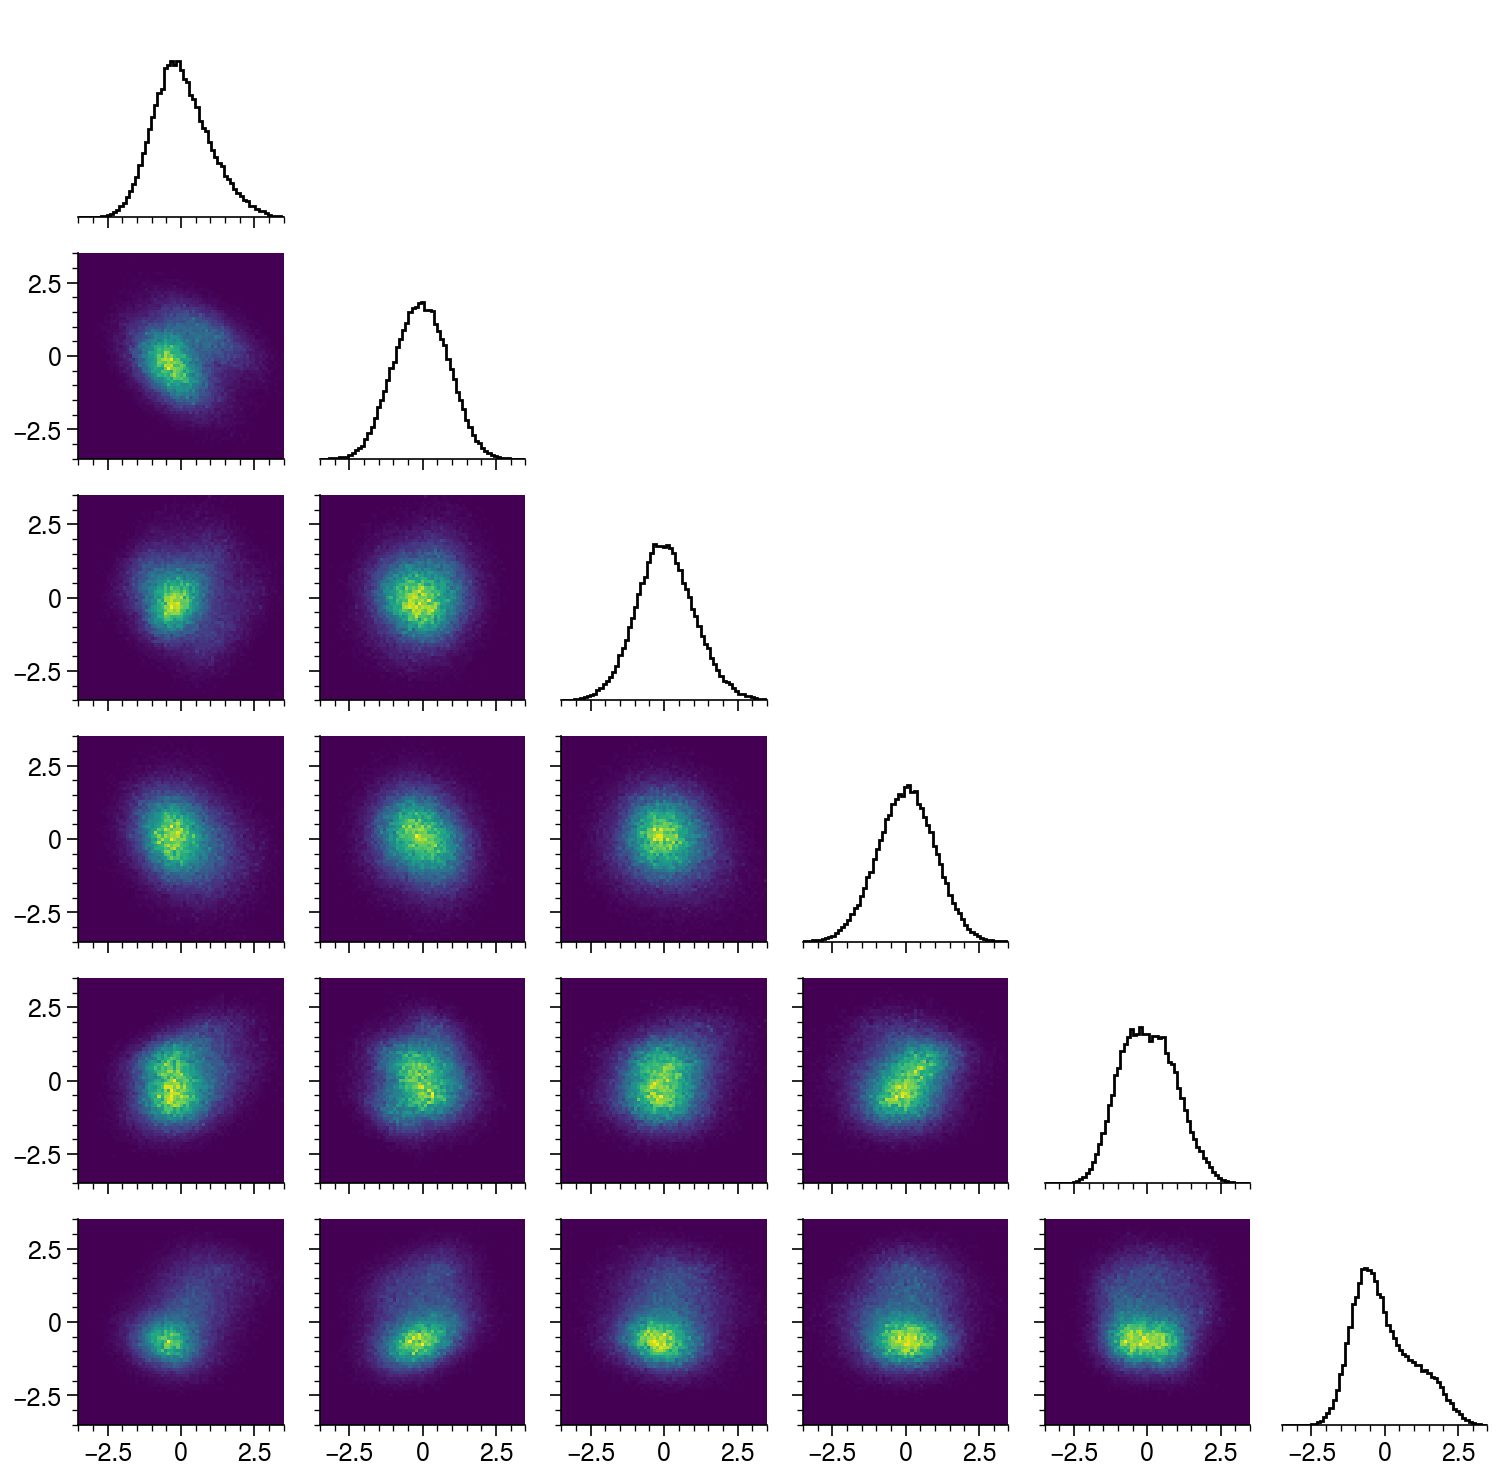

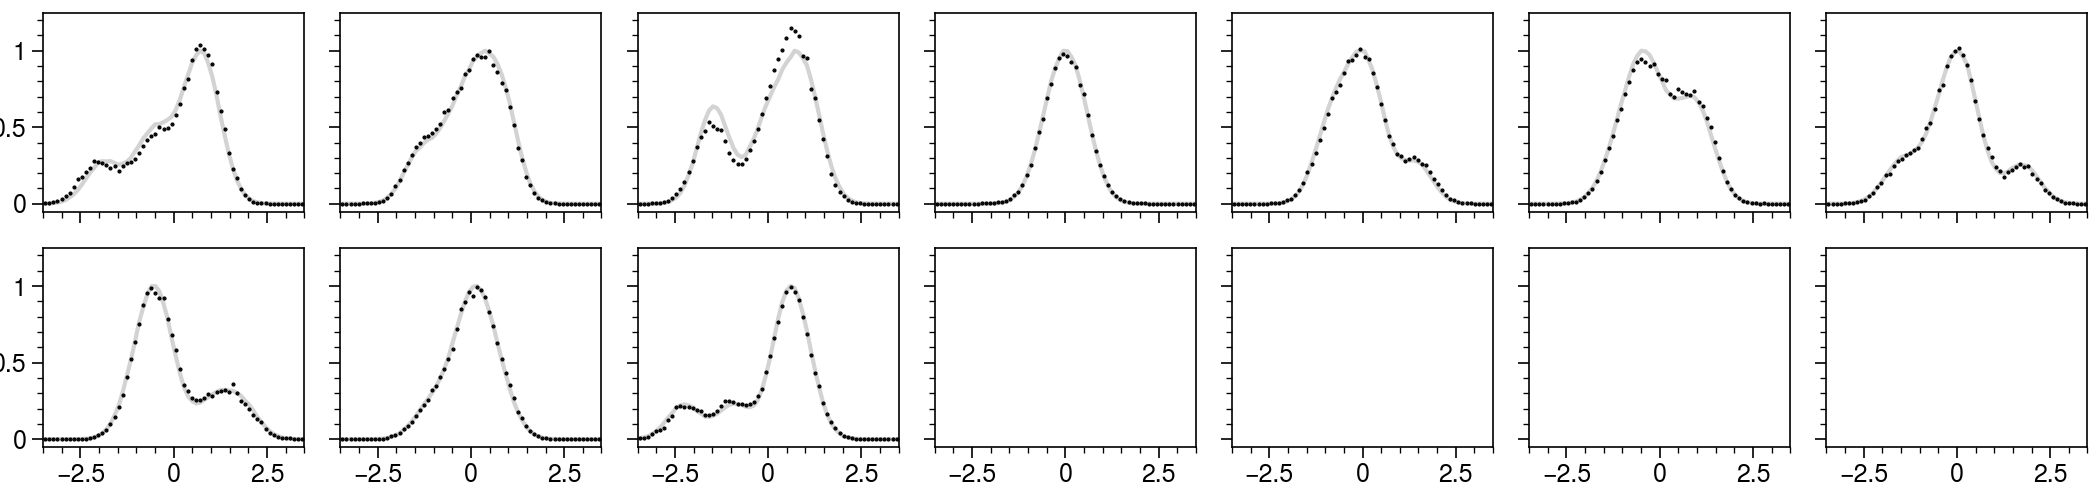

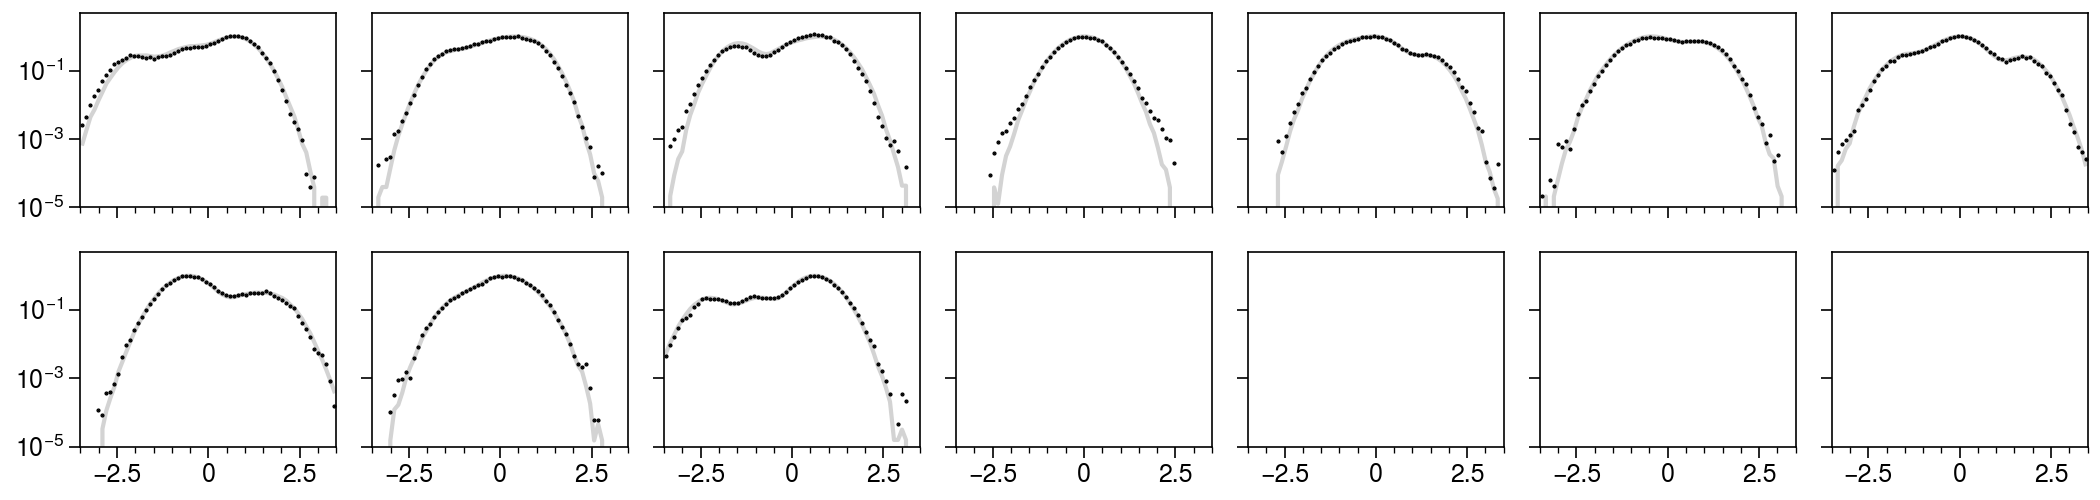

None
epoch = 3
transform=0
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 258/12015 [00:00<00:04, 2572.33it/s]

  4%|██████▎                                                                                                                                            | 518/12015 [00:00<00:04, 2586.66it/s]

  7%|█████████▌                                                                                                                                         | 783/12015 [00:00<00:04, 2612.55it/s]

  9%|████████████▋                                                                                                                                     | 1047/12015 [00:00<00:04, 2622.16it/s]

 11%|███████████████▉                                                                                                                                  | 1310/12015 [00:00<00:04, 2623.44it/s]

 13%|███████████████████                                                                                                                               | 1573/12015 [00:00<00:03, 2619.36it/s]

 15%|██████████████████████▎                                                                                                                           | 1835/12015 [00:00<00:03, 2592.92it/s]

 17%|█████████████████████████▍                                                                                                                        | 2095/12015 [00:00<00:03, 2589.70it/s]

 20%|████████████████████████████▌                                                                                                                     | 2355/12015 [00:00<00:03, 2583.92it/s]

 22%|███████████████████████████████▊                                                                                                                  | 2614/12015 [00:01<00:03, 2581.73it/s]

 24%|██████████████████████████████████▉                                                                                                               | 2873/12015 [00:01<00:03, 2580.93it/s]

 26%|██████████████████████████████████████                                                                                                            | 3133/12015 [00:01<00:03, 2584.90it/s]

 28%|█████████████████████████████████████████▏                                                                                                        | 3393/12015 [00:01<00:03, 2589.17it/s]

 30%|████████████████████████████████████████████▍                                                                                                     | 3652/12015 [00:01<00:03, 2581.70it/s]

 33%|███████████████████████████████████████████████▌                                                                                                  | 3911/12015 [00:01<00:03, 2577.26it/s]

 35%|██████████████████████████████████████████████████▋                                                                                               | 4170/12015 [00:01<00:03, 2579.80it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 4428/12015 [00:01<00:02, 2579.20it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                         | 4686/12015 [00:01<00:02, 2573.40it/s]

 41%|████████████████████████████████████████████████████████████                                                                                      | 4946/12015 [00:01<00:02, 2580.70it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                  | 5207/12015 [00:02<00:02, 2589.28it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                               | 5471/12015 [00:02<00:02, 2603.57it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                            | 5733/12015 [00:02<00:02, 2606.90it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                         | 5994/12015 [00:02<00:02, 2602.24it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 6255/12015 [00:02<00:02, 2597.96it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 6515/12015 [00:02<00:02, 2594.70it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 6775/12015 [00:02<00:02, 2588.55it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                            | 7035/12015 [00:02<00:01, 2590.94it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 7295/12015 [00:02<00:01, 2587.36it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 7557/12015 [00:02<00:01, 2594.41it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                   | 7821/12015 [00:03<00:01, 2605.41it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 8085/12015 [00:03<00:01, 2615.28it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 8348/12015 [00:03<00:01, 2618.90it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 8611/12015 [00:03<00:01, 2621.59it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 8874/12015 [00:03<00:01, 2616.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 9137/12015 [00:03<00:01, 2617.91it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 9403/12015 [00:03<00:00, 2628.57it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 9666/12015 [00:03<00:00, 2612.52it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 9928/12015 [00:03<00:00, 2606.65it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 10189/12015 [00:03<00:00, 2605.40it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 10450/12015 [00:04<00:00, 2599.42it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 10712/12015 [00:04<00:00, 2604.69it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 10977/12015 [00:04<00:00, 2615.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11239/12015 [00:04<00:00, 2614.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 11501/12015 [00:04<00:00, 2613.43it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 11763/12015 [00:04<00:00, 2606.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2599.85it/s]

transform=1
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███                                                                                                                                                | 255/12015 [00:00<00:04, 2541.79it/s]

  4%|██████▎                                                                                                                                            | 515/12015 [00:00<00:04, 2572.95it/s]

  6%|█████████▍                                                                                                                                         | 773/12015 [00:00<00:04, 2571.05it/s]

  9%|████████████▌                                                                                                                                     | 1031/12015 [00:00<00:04, 2546.44it/s]

 11%|███████████████▋                                                                                                                                  | 1289/12015 [00:00<00:04, 2556.06it/s]

 13%|██████████████████▊                                                                                                                               | 1549/12015 [00:00<00:04, 2569.37it/s]

 15%|█████████████████████▉                                                                                                                            | 1809/12015 [00:00<00:03, 2578.17it/s]

 17%|█████████████████████████                                                                                                                         | 2067/12015 [00:00<00:03, 2556.17it/s]

 19%|████████████████████████████▏                                                                                                                     | 2324/12015 [00:00<00:03, 2558.76it/s]

 21%|███████████████████████████████▎                                                                                                                  | 2580/12015 [00:01<00:03, 2554.26it/s]

 24%|██████████████████████████████████▌                                                                                                               | 2840/12015 [00:01<00:03, 2565.91it/s]

 26%|█████████████████████████████████████▋                                                                                                            | 3099/12015 [00:01<00:03, 2571.97it/s]

 28%|████████████████████████████████████████▊                                                                                                         | 3358/12015 [00:01<00:03, 2575.70it/s]

 30%|███████████████████████████████████████████▉                                                                                                      | 3616/12015 [00:01<00:03, 2572.92it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 3874/12015 [00:01<00:03, 2564.18it/s]

 34%|██████████████████████████████████████████████████▏                                                                                               | 4131/12015 [00:01<00:03, 2564.00it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                            | 4390/12015 [00:01<00:02, 2570.01it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                         | 4651/12015 [00:01<00:02, 2580.44it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                      | 4910/12015 [00:01<00:02, 2579.16it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 5168/12015 [00:02<00:02, 2546.17it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                | 5423/12015 [00:02<00:02, 2500.89it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                             | 5674/12015 [00:02<00:02, 2467.43it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                          | 5921/12015 [00:02<00:02, 2456.98it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                       | 6175/12015 [00:02<00:02, 2478.54it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                    | 6428/12015 [00:02<00:02, 2491.81it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                                | 6680/12015 [00:02<00:02, 2499.63it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▎                                                             | 6943/12015 [00:02<00:01, 2536.55it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 7205/12015 [00:02<00:01, 2560.41it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 7469/12015 [00:02<00:01, 2583.80it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 7730/12015 [00:03<00:01, 2591.00it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 7992/12015 [00:03<00:01, 2599.46it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 8255/12015 [00:03<00:01, 2606.44it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 8516/12015 [00:03<00:01, 2600.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 8778/12015 [00:03<00:01, 2605.64it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 9041/12015 [00:03<00:01, 2612.03it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 9304/12015 [00:03<00:01, 2616.72it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 9567/12015 [00:03<00:00, 2620.11it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 9830/12015 [00:03<00:00, 2583.08it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 10089/12015 [00:03<00:00, 2557.33it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 10345/12015 [00:04<00:00, 2546.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 10600/12015 [00:04<00:00, 2518.97it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 10852/12015 [00:04<00:00, 2499.01it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 11102/12015 [00:04<00:00, 2493.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 11352/12015 [00:04<00:00, 2488.45it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 11603/12015 [00:04<00:00, 2493.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 11854/12015 [00:04<00:00, 2498.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2548.38it/s]

transform=2
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 262/12015 [00:00<00:04, 2615.21it/s]

  4%|██████▍                                                                                                                                            | 527/12015 [00:00<00:04, 2631.12it/s]

  7%|█████████▋                                                                                                                                         | 791/12015 [00:00<00:04, 2632.27it/s]

  9%|████████████▊                                                                                                                                     | 1055/12015 [00:00<00:04, 2602.23it/s]

 11%|████████████████                                                                                                                                  | 1317/12015 [00:00<00:04, 2605.59it/s]

 13%|███████████████████▏                                                                                                                              | 1580/12015 [00:00<00:03, 2613.54it/s]

 15%|██████████████████████▍                                                                                                                           | 1845/12015 [00:00<00:03, 2623.37it/s]

 18%|█████████████████████████▌                                                                                                                        | 2108/12015 [00:00<00:03, 2587.67it/s]

 20%|████████████████████████████▊                                                                                                                     | 2367/12015 [00:00<00:03, 2576.61it/s]

 22%|███████████████████████████████▉                                                                                                                  | 2631/12015 [00:01<00:03, 2593.89it/s]

 24%|███████████████████████████████████▏                                                                                                              | 2894/12015 [00:01<00:03, 2604.19it/s]

 26%|██████████████████████████████████████▎                                                                                                           | 3156/12015 [00:01<00:03, 2608.21it/s]

 28%|█████████████████████████████████████████▌                                                                                                        | 3421/12015 [00:01<00:03, 2620.31it/s]

 31%|████████████████████████████████████████████▊                                                                                                     | 3687/12015 [00:01<00:03, 2631.11it/s]

 33%|████████████████████████████████████████████████                                                                                                  | 3951/12015 [00:01<00:03, 2629.15it/s]

 35%|███████████████████████████████████████████████████▏                                                                                              | 4214/12015 [00:01<00:02, 2615.57it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                           | 4476/12015 [00:01<00:02, 2615.95it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                        | 4740/12015 [00:01<00:02, 2621.35it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                     | 5005/12015 [00:01<00:02, 2629.40it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                  | 5268/12015 [00:02<00:02, 2613.09it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 5530/12015 [00:02<00:02, 2610.88it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                           | 5792/12015 [00:02<00:02, 2610.25it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 6054/12015 [00:02<00:02, 2606.70it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 6315/12015 [00:02<00:02, 2583.45it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                  | 6574/12015 [00:02<00:02, 2546.92it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                               | 6829/12015 [00:02<00:02, 2526.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                            | 7082/12015 [00:02<00:01, 2524.85it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 7337/12015 [00:02<00:01, 2531.43it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 7591/12015 [00:02<00:01, 2530.97it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 7850/12015 [00:03<00:01, 2546.65it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 8108/12015 [00:03<00:01, 2556.09it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 8368/12015 [00:03<00:01, 2568.05it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 8632/12015 [00:03<00:01, 2589.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 8894/12015 [00:03<00:01, 2596.78it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 9155/12015 [00:03<00:01, 2600.45it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 9419/12015 [00:03<00:00, 2610.33it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 9683/12015 [00:03<00:00, 2619.22it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 9949/12015 [00:03<00:00, 2631.08it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 10213/12015 [00:03<00:00, 2615.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 10475/12015 [00:04<00:00, 2614.48it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 10740/12015 [00:04<00:00, 2623.19it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 11007/12015 [00:04<00:00, 2637.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 11273/12015 [00:04<00:00, 2643.29it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 11539/12015 [00:04<00:00, 2645.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 11804/12015 [00:04<00:00, 2633.31it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2603.01it/s]

transform=3
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███                                                                                                                                                | 248/12015 [00:00<00:04, 2473.42it/s]

  4%|██████▏                                                                                                                                            | 502/12015 [00:00<00:04, 2507.42it/s]

  6%|█████████▏                                                                                                                                         | 755/12015 [00:00<00:04, 2515.06it/s]

  8%|████████████▎                                                                                                                                     | 1010/12015 [00:00<00:04, 2526.36it/s]

 11%|███████████████▎                                                                                                                                  | 1265/12015 [00:00<00:04, 2531.91it/s]

 13%|██████████████████▍                                                                                                                               | 1519/12015 [00:00<00:04, 2529.26it/s]

 15%|█████████████████████▌                                                                                                                            | 1772/12015 [00:00<00:04, 2528.46it/s]

 17%|████████████████████████▋                                                                                                                         | 2028/12015 [00:00<00:03, 2536.76it/s]

 19%|███████████████████████████▋                                                                                                                      | 2282/12015 [00:00<00:03, 2532.10it/s]

 21%|██████████████████████████████▊                                                                                                                   | 2536/12015 [00:01<00:03, 2523.38it/s]

 23%|█████████████████████████████████▉                                                                                                                | 2789/12015 [00:01<00:03, 2513.35it/s]

 25%|████████████████████████████████████▉                                                                                                             | 3042/12015 [00:01<00:03, 2515.76it/s]

 27%|████████████████████████████████████████                                                                                                          | 3297/12015 [00:01<00:03, 2524.00it/s]

 30%|███████████████████████████████████████████▏                                                                                                      | 3553/12015 [00:01<00:03, 2534.13it/s]

 32%|██████████████████████████████████████████████▎                                                                                                   | 3815/12015 [00:01<00:03, 2559.14it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                | 4078/12015 [00:01<00:03, 2577.71it/s]

 36%|████████████████████████████████████████████████████▊                                                                                             | 4343/12015 [00:01<00:02, 2596.86it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                          | 4604/12015 [00:01<00:02, 2599.99it/s]

 40%|███████████████████████████████████████████████████████████                                                                                       | 4865/12015 [00:01<00:02, 2576.69it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                   | 5123/12015 [00:02<00:02, 2568.24it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 5386/12015 [00:02<00:02, 2583.35it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                             | 5651/12015 [00:02<00:02, 2601.46it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 5914/12015 [00:02<00:02, 2609.24it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                       | 6175/12015 [00:02<00:02, 2603.60it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                   | 6437/12015 [00:02<00:02, 2605.98it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 6700/12015 [00:02<00:02, 2612.68it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 6962/12015 [00:02<00:01, 2614.56it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7225/12015 [00:02<00:01, 2618.14it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                       | 7490/12015 [00:02<00:01, 2625.77it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 7753/12015 [00:03<00:01, 2622.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 8016/12015 [00:03<00:01, 2594.57it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 8276/12015 [00:03<00:01, 2593.23it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 8537/12015 [00:03<00:01, 2598.15it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 8797/12015 [00:03<00:01, 2591.33it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 9057/12015 [00:03<00:01, 2578.99it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 9316/12015 [00:03<00:01, 2580.57it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 9579/12015 [00:03<00:00, 2594.04it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 9843/12015 [00:03<00:00, 2605.32it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 10109/12015 [00:03<00:00, 2618.97it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 10373/12015 [00:04<00:00, 2624.75it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 10637/12015 [00:04<00:00, 2628.32it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 10903/12015 [00:04<00:00, 2636.43it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 11167/12015 [00:04<00:00, 2606.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 11430/12015 [00:04<00:00, 2612.24it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 11695/12015 [00:04<00:00, 2622.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 11960/12015 [00:04<00:00, 2628.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2583.55it/s]

transform=4
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███                                                                                                                                                | 252/12015 [00:00<00:04, 2519.77it/s]

  4%|██████▎                                                                                                                                            | 513/12015 [00:00<00:04, 2570.97it/s]

  6%|█████████▍                                                                                                                                         | 773/12015 [00:00<00:04, 2582.35it/s]

  9%|████████████▌                                                                                                                                     | 1034/12015 [00:00<00:04, 2591.10it/s]

 11%|███████████████▊                                                                                                                                  | 1297/12015 [00:00<00:04, 2601.21it/s]

 13%|██████████████████▉                                                                                                                               | 1558/12015 [00:00<00:04, 2594.94it/s]

 15%|██████████████████████                                                                                                                            | 1820/12015 [00:00<00:03, 2601.49it/s]

 17%|█████████████████████████▎                                                                                                                        | 2081/12015 [00:00<00:03, 2593.45it/s]

 20%|████████████████████████████▍                                                                                                                     | 2343/12015 [00:00<00:03, 2599.10it/s]

 22%|███████████████████████████████▋                                                                                                                  | 2606/12015 [00:01<00:03, 2605.67it/s]

 24%|██████████████████████████████████▊                                                                                                               | 2868/12015 [00:01<00:03, 2608.90it/s]

 26%|██████████████████████████████████████                                                                                                            | 3133/12015 [00:01<00:03, 2620.40it/s]

 28%|█████████████████████████████████████████▎                                                                                                        | 3396/12015 [00:01<00:03, 2604.67it/s]

 30%|████████████████████████████████████████████▍                                                                                                     | 3662/12015 [00:01<00:03, 2618.34it/s]

 33%|███████████████████████████████████████████████▋                                                                                                  | 3929/12015 [00:01<00:03, 2630.93it/s]

 35%|██████████████████████████████████████████████████▉                                                                                               | 4193/12015 [00:01<00:02, 2625.00it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                           | 4456/12015 [00:01<00:02, 2619.78it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                        | 4719/12015 [00:01<00:02, 2620.75it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                     | 4984/12015 [00:01<00:02, 2629.36it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                  | 5248/12015 [00:02<00:02, 2629.94it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                               | 5512/12015 [00:02<00:02, 2630.39it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                           | 5776/12015 [00:02<00:02, 2631.13it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                        | 6041/12015 [00:02<00:02, 2636.00it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 6307/12015 [00:02<00:02, 2641.04it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                  | 6572/12015 [00:02<00:02, 2616.38it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                               | 6834/12015 [00:02<00:01, 2603.67it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                           | 7095/12015 [00:02<00:01, 2601.35it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 7359/12015 [00:02<00:01, 2611.62it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 7623/12015 [00:02<00:01, 2618.07it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 7885/12015 [00:03<00:01, 2605.57it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 8146/12015 [00:03<00:01, 2605.35it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 8410/12015 [00:03<00:01, 2614.91it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 8672/12015 [00:03<00:01, 2606.06it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 8933/12015 [00:03<00:01, 2595.39it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 9196/12015 [00:03<00:01, 2603.70it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 9461/12015 [00:03<00:00, 2615.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 9727/12015 [00:03<00:00, 2628.51it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 9993/12015 [00:03<00:00, 2635.70it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 10257/12015 [00:03<00:00, 2633.39it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 10523/12015 [00:04<00:00, 2639.52it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 10789/12015 [00:04<00:00, 2644.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 11055/12015 [00:04<00:00, 2646.43it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 11321/12015 [00:04<00:00, 2648.26it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 11588/12015 [00:04<00:00, 2652.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 11854/12015 [00:04<00:00, 2645.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2618.94it/s]

transform=5
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 262/12015 [00:00<00:04, 2617.87it/s]

  4%|██████▍                                                                                                                                            | 526/12015 [00:00<00:04, 2630.85it/s]

  7%|█████████▋                                                                                                                                         | 790/12015 [00:00<00:04, 2623.60it/s]

  9%|████████████▊                                                                                                                                     | 1056/12015 [00:00<00:04, 2637.27it/s]

 11%|████████████████                                                                                                                                  | 1320/12015 [00:00<00:04, 2633.38it/s]

 13%|███████████████████▎                                                                                                                              | 1587/12015 [00:00<00:03, 2643.77it/s]

 15%|██████████████████████▌                                                                                                                           | 1854/12015 [00:00<00:03, 2651.16it/s]

 18%|█████████████████████████▊                                                                                                                        | 2120/12015 [00:00<00:03, 2645.09it/s]

 20%|████████████████████████████▉                                                                                                                     | 2385/12015 [00:00<00:03, 2639.18it/s]

 22%|████████████████████████████████▏                                                                                                                 | 2653/12015 [00:01<00:03, 2649.69it/s]

 24%|███████████████████████████████████▍                                                                                                              | 2920/12015 [00:01<00:03, 2654.96it/s]

 27%|██████████████████████████████████████▋                                                                                                           | 3187/12015 [00:01<00:03, 2659.38it/s]

 29%|█████████████████████████████████████████▉                                                                                                        | 3454/12015 [00:01<00:03, 2661.51it/s]

 31%|█████████████████████████████████████████████▏                                                                                                    | 3721/12015 [00:01<00:03, 2663.12it/s]

 33%|████████████████████████████████████████████████▍                                                                                                 | 3988/12015 [00:01<00:03, 2664.78it/s]

 35%|███████████████████████████████████████████████████▋                                                                                              | 4255/12015 [00:01<00:02, 2658.63it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                           | 4523/12015 [00:01<00:02, 2662.31it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                       | 4790/12015 [00:01<00:02, 2664.34it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                    | 5058/12015 [00:01<00:02, 2666.43it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                 | 5326/12015 [00:02<00:02, 2669.22it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                              | 5593/12015 [00:02<00:02, 2666.70it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                          | 5860/12015 [00:02<00:02, 2660.37it/s]

 51%|██████████████████████████████████████████████████████████████████████████▍                                                                       | 6127/12015 [00:02<00:02, 2656.67it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                    | 6393/12015 [00:02<00:02, 2644.23it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                 | 6658/12015 [00:02<00:02, 2640.25it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                             | 6924/12015 [00:02<00:01, 2644.67it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▎                                                          | 7190/12015 [00:02<00:01, 2647.74it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 7455/12015 [00:02<00:01, 2646.24it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 7720/12015 [00:02<00:01, 2644.66it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 7986/12015 [00:03<00:01, 2648.08it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 8253/12015 [00:03<00:01, 2651.79it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 8519/12015 [00:03<00:01, 2653.46it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 8785/12015 [00:03<00:01, 2652.41it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 9051/12015 [00:03<00:01, 2647.07it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 9316/12015 [00:03<00:01, 2643.76it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 9581/12015 [00:03<00:00, 2616.07it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 9843/12015 [00:03<00:00, 2599.61it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 10104/12015 [00:03<00:00, 2600.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 10365/12015 [00:03<00:00, 2585.20it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 10625/12015 [00:04<00:00, 2589.36it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 10889/12015 [00:04<00:00, 2603.31it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 11150/12015 [00:04<00:00, 2592.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 11410/12015 [00:04<00:00, 2589.33it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 11673/12015 [00:04<00:00, 2601.43it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 11934/12015 [00:04<00:00, 2593.46it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2635.35it/s]

transform=6
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 261/12015 [00:00<00:04, 2606.01it/s]

  4%|██████▍                                                                                                                                            | 524/12015 [00:00<00:04, 2616.26it/s]

  7%|█████████▋                                                                                                                                         | 789/12015 [00:00<00:04, 2628.37it/s]

  9%|████████████▊                                                                                                                                     | 1052/12015 [00:00<00:04, 2627.42it/s]

 11%|███████████████▉                                                                                                                                  | 1315/12015 [00:00<00:04, 2627.18it/s]

 13%|███████████████████▏                                                                                                                              | 1580/12015 [00:00<00:03, 2634.86it/s]

 15%|██████████████████████▍                                                                                                                           | 1847/12015 [00:00<00:03, 2645.14it/s]

 18%|█████████████████████████▋                                                                                                                        | 2112/12015 [00:00<00:03, 2646.67it/s]

 20%|████████████████████████████▉                                                                                                                     | 2377/12015 [00:00<00:03, 2646.34it/s]

 22%|████████████████████████████████                                                                                                                  | 2642/12015 [00:01<00:03, 2612.73it/s]

 24%|███████████████████████████████████▎                                                                                                              | 2904/12015 [00:01<00:03, 2609.53it/s]

 26%|██████████████████████████████████████▍                                                                                                           | 3166/12015 [00:01<00:03, 2608.31it/s]

 29%|█████████████████████████████████████████▋                                                                                                        | 3428/12015 [00:01<00:03, 2609.66it/s]

 31%|████████████████████████████████████████████▊                                                                                                     | 3692/12015 [00:01<00:03, 2618.50it/s]

 33%|████████████████████████████████████████████████                                                                                                  | 3956/12015 [00:01<00:03, 2623.74it/s]

 35%|███████████████████████████████████████████████████▎                                                                                              | 4220/12015 [00:01<00:02, 2628.53it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                           | 4485/12015 [00:01<00:02, 2633.12it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                        | 4749/12015 [00:01<00:02, 2630.13it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                     | 5013/12015 [00:01<00:02, 2628.27it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 5279/12015 [00:02<00:02, 2637.64it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                              | 5545/12015 [00:02<00:02, 2642.75it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                           | 5810/12015 [00:02<00:02, 2640.39it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                        | 6075/12015 [00:02<00:02, 2637.68it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                     | 6339/12015 [00:02<00:02, 2629.59it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 6604/12015 [00:02<00:02, 2633.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                              | 6870/12015 [00:02<00:01, 2640.41it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                           | 7137/12015 [00:02<00:01, 2646.71it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 7402/12015 [00:02<00:01, 2639.01it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 7667/12015 [00:02<00:01, 2640.10it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 7934/12015 [00:03<00:01, 2646.63it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 8201/12015 [00:03<00:01, 2651.62it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 8467/12015 [00:03<00:01, 2643.32it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 8732/12015 [00:03<00:01, 2638.41it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 8996/12015 [00:03<00:01, 2634.01it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 9260/12015 [00:03<00:01, 2625.64it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 9523/12015 [00:03<00:00, 2622.25it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 9786/12015 [00:03<00:00, 2621.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 10049/12015 [00:03<00:00, 2622.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 10312/12015 [00:03<00:00, 2619.00it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 10574/12015 [00:04<00:00, 2611.84it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 10836/12015 [00:04<00:00, 2608.43it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 11099/12015 [00:04<00:00, 2613.43it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 11362/12015 [00:04<00:00, 2616.49it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 11628/12015 [00:04<00:00, 2628.58it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 11892/12015 [00:04<00:00, 2631.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2629.40it/s]

transform=7
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 263/12015 [00:00<00:04, 2629.19it/s]

  4%|██████▍                                                                                                                                            | 529/12015 [00:00<00:04, 2644.07it/s]

  7%|█████████▋                                                                                                                                         | 794/12015 [00:00<00:04, 2632.15it/s]

  9%|████████████▊                                                                                                                                     | 1058/12015 [00:00<00:04, 2632.91it/s]

 11%|████████████████                                                                                                                                  | 1322/12015 [00:00<00:04, 2612.89it/s]

 13%|███████████████████▏                                                                                                                              | 1584/12015 [00:00<00:04, 2591.15it/s]

 15%|██████████████████████▍                                                                                                                           | 1844/12015 [00:00<00:03, 2561.75it/s]

 18%|█████████████████████████▌                                                                                                                        | 2106/12015 [00:00<00:03, 2577.55it/s]

 20%|████████████████████████████▊                                                                                                                     | 2372/12015 [00:00<00:03, 2602.31it/s]

 22%|████████████████████████████████                                                                                                                  | 2634/12015 [00:01<00:03, 2607.11it/s]

 24%|███████████████████████████████████▏                                                                                                              | 2897/12015 [00:01<00:03, 2612.04it/s]

 26%|██████████████████████████████████████▍                                                                                                           | 3159/12015 [00:01<00:03, 2609.89it/s]

 28%|█████████████████████████████████████████▌                                                                                                        | 3423/12015 [00:01<00:03, 2618.09it/s]

 31%|████████████████████████████████████████████▊                                                                                                     | 3688/12015 [00:01<00:03, 2625.50it/s]

 33%|████████████████████████████████████████████████                                                                                                  | 3954/12015 [00:01<00:03, 2635.70it/s]

 35%|███████████████████████████████████████████████████▎                                                                                              | 4218/12015 [00:01<00:02, 2611.06it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                           | 4480/12015 [00:01<00:02, 2611.88it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                        | 4742/12015 [00:01<00:02, 2613.38it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                     | 5008/12015 [00:01<00:02, 2626.09it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                  | 5275/12015 [00:02<00:02, 2637.64it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                              | 5539/12015 [00:02<00:02, 2633.55it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                           | 5803/12015 [00:02<00:02, 2631.01it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                        | 6067/12015 [00:02<00:02, 2630.10it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                     | 6331/12015 [00:02<00:02, 2631.86it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 6595/12015 [00:02<00:02, 2632.11it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                              | 6859/12015 [00:02<00:01, 2633.09it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 7124/12015 [00:02<00:01, 2636.29it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 7388/12015 [00:02<00:01, 2637.10it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7653/12015 [00:02<00:01, 2638.41it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 7919/12015 [00:03<00:01, 2643.03it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 8184/12015 [00:03<00:01, 2641.33it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 8449/12015 [00:03<00:01, 2641.48it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 8714/12015 [00:03<00:01, 2643.74it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 8980/12015 [00:03<00:01, 2646.71it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 9245/12015 [00:03<00:01, 2633.45it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 9509/12015 [00:03<00:00, 2635.31it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 9773/12015 [00:03<00:00, 2636.43it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 10039/12015 [00:03<00:00, 2643.16it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 10304/12015 [00:03<00:00, 2642.24it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 10570/12015 [00:04<00:00, 2647.18it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 10835/12015 [00:04<00:00, 2646.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 11100/12015 [00:04<00:00, 2641.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 11365/12015 [00:04<00:00, 2638.78it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 11629/12015 [00:04<00:00, 2629.94it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 11894/12015 [00:04<00:00, 2635.34it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2628.12it/s]

transform=8
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 260/12015 [00:00<00:04, 2596.18it/s]

  4%|██████▍                                                                                                                                            | 524/12015 [00:00<00:04, 2617.54it/s]

  7%|█████████▋                                                                                                                                         | 787/12015 [00:00<00:04, 2620.46it/s]

  9%|████████████▊                                                                                                                                     | 1051/12015 [00:00<00:04, 2625.29it/s]

 11%|███████████████▉                                                                                                                                  | 1314/12015 [00:00<00:04, 2625.78it/s]

 13%|███████████████████▏                                                                                                                              | 1578/12015 [00:00<00:03, 2629.44it/s]

 15%|██████████████████████▎                                                                                                                           | 1841/12015 [00:00<00:03, 2625.11it/s]

 18%|█████████████████████████▌                                                                                                                        | 2104/12015 [00:00<00:03, 2613.66it/s]

 20%|████████████████████████████▊                                                                                                                     | 2366/12015 [00:00<00:03, 2612.69it/s]

 22%|███████████████████████████████▉                                                                                                                  | 2629/12015 [00:01<00:03, 2617.29it/s]

 24%|███████████████████████████████████▏                                                                                                              | 2893/12015 [00:01<00:03, 2621.47it/s]

 26%|██████████████████████████████████████▎                                                                                                           | 3156/12015 [00:01<00:03, 2619.66it/s]

 28%|█████████████████████████████████████████▌                                                                                                        | 3418/12015 [00:01<00:03, 2615.18it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 3680/12015 [00:01<00:03, 2614.28it/s]

 33%|███████████████████████████████████████████████▉                                                                                                  | 3942/12015 [00:01<00:03, 2614.80it/s]

 35%|███████████████████████████████████████████████████                                                                                               | 4206/12015 [00:01<00:02, 2622.29it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 4471/12015 [00:01<00:02, 2627.96it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                        | 4734/12015 [00:01<00:02, 2627.18it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                     | 4998/12015 [00:01<00:02, 2630.74it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                  | 5263/12015 [00:02<00:02, 2635.87it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 5528/12015 [00:02<00:02, 2639.12it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                           | 5794/12015 [00:02<00:02, 2643.90it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                        | 6060/12015 [00:02<00:02, 2647.56it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                     | 6325/12015 [00:02<00:02, 2634.93it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 6589/12015 [00:02<00:02, 2628.48it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                              | 6855/12015 [00:02<00:01, 2637.71it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 7122/12015 [00:02<00:01, 2645.49it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 7387/12015 [00:02<00:01, 2635.81it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7651/12015 [00:02<00:01, 2629.77it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 7916/12015 [00:03<00:01, 2633.67it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 8180/12015 [00:03<00:01, 2626.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 8443/12015 [00:03<00:01, 2623.21it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 8706/12015 [00:03<00:01, 2619.53it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 8968/12015 [00:03<00:01, 2617.69it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 9230/12015 [00:03<00:01, 2616.03it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 9492/12015 [00:03<00:00, 2612.99it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 9754/12015 [00:03<00:00, 2612.37it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 10016/12015 [00:03<00:00, 2605.96it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 10277/12015 [00:03<00:00, 2604.05it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 10538/12015 [00:04<00:00, 2603.65it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 10803/12015 [00:04<00:00, 2615.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 11065/12015 [00:04<00:00, 2598.27it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 11325/12015 [00:04<00:00, 2546.67it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 11580/12015 [00:04<00:00, 2522.29it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 11833/12015 [00:04<00:00, 2506.15it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2608.62it/s]

transform=9
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                               | 256/12015 [00:00<00:04, 2559.93it/s]

  4%|██████▎                                                                                                                                            | 512/12015 [00:00<00:04, 2503.46it/s]

  6%|█████████▎                                                                                                                                         | 763/12015 [00:00<00:04, 2488.76it/s]

  8%|████████████▎                                                                                                                                     | 1015/12015 [00:00<00:04, 2499.90it/s]

 11%|███████████████▍                                                                                                                                  | 1271/12015 [00:00<00:04, 2517.99it/s]

 13%|██████████████████▌                                                                                                                               | 1529/12015 [00:00<00:04, 2535.74it/s]

 15%|█████████████████████▋                                                                                                                            | 1783/12015 [00:00<00:04, 2534.08it/s]

 17%|████████████████████████▊                                                                                                                         | 2044/12015 [00:00<00:03, 2556.43it/s]

 19%|████████████████████████████                                                                                                                      | 2308/12015 [00:00<00:03, 2581.40it/s]

 21%|███████████████████████████████▎                                                                                                                  | 2574/12015 [00:01<00:03, 2603.50it/s]

 24%|██████████████████████████████████▍                                                                                                               | 2835/12015 [00:01<00:03, 2595.32it/s]

 26%|█████████████████████████████████████▌                                                                                                            | 3096/12015 [00:01<00:03, 2597.13it/s]

 28%|████████████████████████████████████████▊                                                                                                         | 3356/12015 [00:01<00:03, 2568.48it/s]

 30%|███████████████████████████████████████████▉                                                                                                      | 3613/12015 [00:01<00:03, 2542.19it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 3868/12015 [00:01<00:03, 2530.53it/s]

 34%|██████████████████████████████████████████████████                                                                                                | 4122/12015 [00:01<00:03, 2510.79it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                            | 4374/12015 [00:01<00:03, 2502.10it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                         | 4627/12015 [00:01<00:02, 2506.39it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                      | 4880/12015 [00:01<00:02, 2512.46it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                   | 5132/12015 [00:02<00:02, 2506.86it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 5386/12015 [00:02<00:02, 2513.51it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                             | 5640/12015 [00:02<00:02, 2518.87it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                          | 5898/12015 [00:02<00:02, 2536.37it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                       | 6160/12015 [00:02<00:02, 2560.75it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                    | 6425/12015 [00:02<00:02, 2585.16it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                                | 6689/12015 [00:02<00:02, 2600.51it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 6954/12015 [00:02<00:01, 2612.41it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                          | 7221/12015 [00:02<00:01, 2628.09it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 7484/12015 [00:02<00:01, 2626.43it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 7747/12015 [00:03<00:01, 2623.51it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 8011/12015 [00:03<00:01, 2625.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 8277/12015 [00:03<00:01, 2634.15it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 8541/12015 [00:03<00:01, 2632.19it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 8805/12015 [00:03<00:01, 2630.32it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 9069/12015 [00:03<00:01, 2619.90it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 9332/12015 [00:03<00:01, 2612.60it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 9594/12015 [00:03<00:00, 2612.47it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 9856/12015 [00:03<00:00, 2588.06it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 10115/12015 [00:03<00:00, 2563.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 10372/12015 [00:04<00:00, 2548.51it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 10627/12015 [00:04<00:00, 2540.74it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 10883/12015 [00:04<00:00, 2545.22it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 11143/12015 [00:04<00:00, 2561.03it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 11402/12015 [00:04<00:00, 2567.30it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 11659/12015 [00:04<00:00, 2564.65it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 11919/12015 [00:04<00:00, 2573.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2566.89it/s]

  0%|                                                                                                                                                               | 0/14031 [00:00<?, ?it/s]

  2%|██▋                                                                                                                                                | 260/14031 [00:00<00:05, 2597.22it/s]

  4%|█████▍                                                                                                                                             | 522/14031 [00:00<00:05, 2605.19it/s]

  6%|████████▏                                                                                                                                          | 783/14031 [00:00<00:05, 2604.84it/s]

  7%|██████████▊                                                                                                                                       | 1044/14031 [00:00<00:05, 2589.97it/s]

  9%|█████████████▌                                                                                                                                    | 1304/14031 [00:00<00:04, 2559.20it/s]

 11%|████████████████▏                                                                                                                                 | 1560/14031 [00:00<00:04, 2549.90it/s]

 13%|██████████████████▉                                                                                                                               | 1819/14031 [00:00<00:04, 2559.51it/s]

 15%|█████████████████████▌                                                                                                                            | 2077/14031 [00:00<00:04, 2565.61it/s]

 17%|████████████████████████▎                                                                                                                         | 2334/14031 [00:00<00:04, 2554.57it/s]

 18%|██████████████████████████▉                                                                                                                       | 2591/14031 [00:01<00:04, 2557.86it/s]

 20%|█████████████████████████████▋                                                                                                                    | 2849/14031 [00:01<00:04, 2564.19it/s]

 22%|████████████████████████████████▍                                                                                                                 | 3114/14031 [00:01<00:04, 2589.46it/s]

 24%|███████████████████████████████████▏                                                                                                              | 3379/14031 [00:01<00:04, 2606.40it/s]

 26%|█████████████████████████████████████▉                                                                                                            | 3643/14031 [00:01<00:03, 2613.84it/s]

 28%|████████████████████████████████████████▋                                                                                                         | 3905/14031 [00:01<00:03, 2605.92it/s]

 30%|███████████████████████████████████████████▎                                                                                                      | 4166/14031 [00:01<00:03, 2602.91it/s]

 32%|██████████████████████████████████████████████                                                                                                    | 4431/14031 [00:01<00:03, 2616.01it/s]

 33%|████████████████████████████████████████████████▊                                                                                                 | 4693/14031 [00:01<00:03, 2611.69it/s]

 35%|███████████████████████████████████████████████████▌                                                                                              | 4955/14031 [00:01<00:03, 2612.84it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 5219/14031 [00:02<00:03, 2620.69it/s]

 39%|█████████████████████████████████████████████████████████                                                                                         | 5485/14031 [00:02<00:03, 2630.01it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                      | 5752/14031 [00:02<00:03, 2639.99it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                   | 6019/14031 [00:02<00:03, 2646.51it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 6284/14031 [00:02<00:02, 2633.44it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                             | 6548/14031 [00:02<00:02, 2622.67it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                           | 6812/14031 [00:02<00:02, 2627.55it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                        | 7076/14031 [00:02<00:02, 2630.70it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                     | 7343/14031 [00:02<00:02, 2640.49it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 7608/14031 [00:02<00:02, 2641.32it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                                | 7873/14031 [00:03<00:02, 2638.93it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                             | 8137/14031 [00:03<00:02, 2633.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▍                                                          | 8402/14031 [00:03<00:02, 2637.22it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 8667/14031 [00:03<00:02, 2640.55it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 8933/14031 [00:03<00:01, 2643.64it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 9198/14031 [00:03<00:01, 2645.01it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 9464/14031 [00:03<00:01, 2649.12it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 9731/14031 [00:03<00:01, 2652.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 9998/14031 [00:03<00:01, 2657.20it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 10264/14031 [00:03<00:01, 2636.77it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 10528/14031 [00:04<00:01, 2632.42it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 10795/14031 [00:04<00:01, 2641.97it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 11060/14031 [00:04<00:01, 2642.96it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 11325/14031 [00:04<00:01, 2640.97it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 11590/14031 [00:04<00:00, 2636.83it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 11855/14031 [00:04<00:00, 2639.49it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 12121/14031 [00:04<00:00, 2643.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 12387/14031 [00:04<00:00, 2646.90it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 12654/14031 [00:04<00:00, 2651.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 12920/14031 [00:04<00:00, 2645.11it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 13185/14031 [00:05<00:00, 2638.24it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 13449/14031 [00:05<00:00, 2615.84it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 13713/14031 [00:05<00:00, 2621.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 13979/14031 [00:05<00:00, 2631.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:05<00:00, 2621.61it/s]

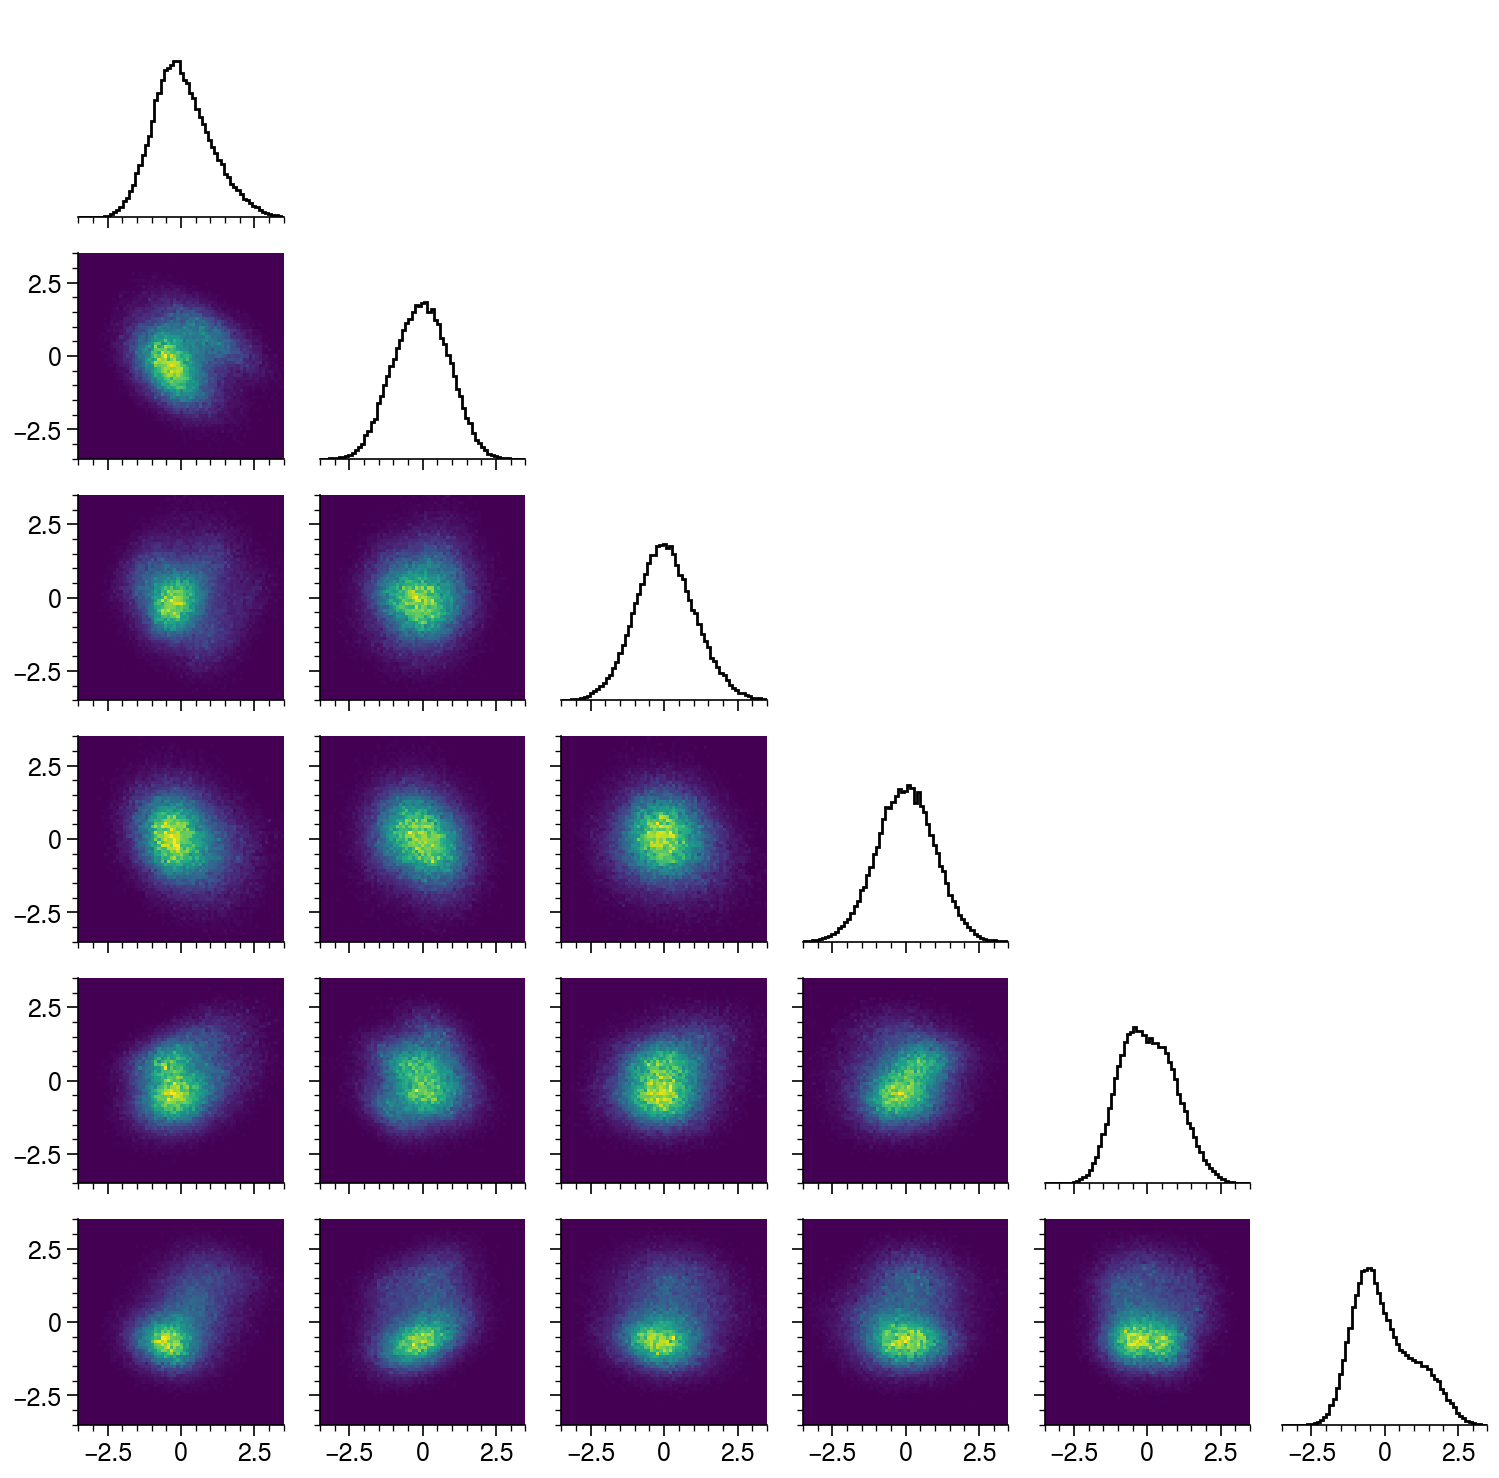

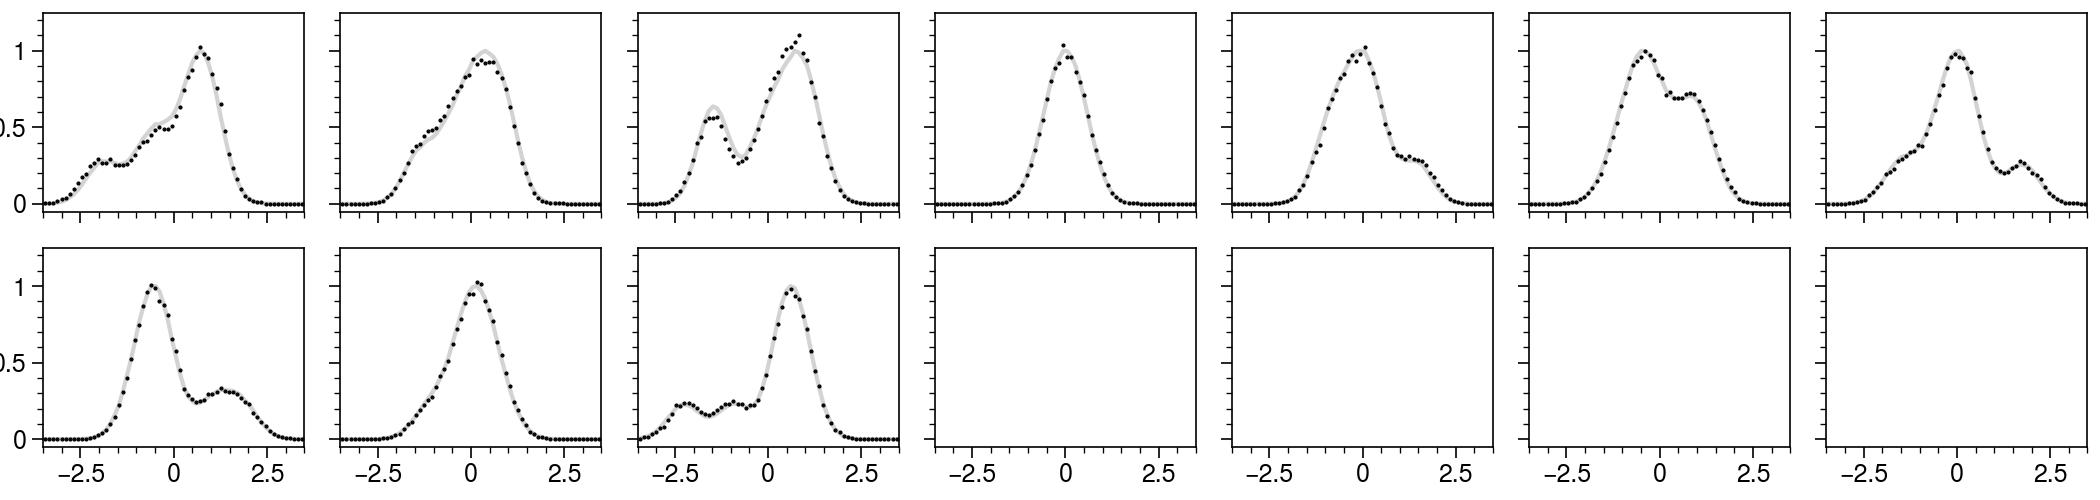

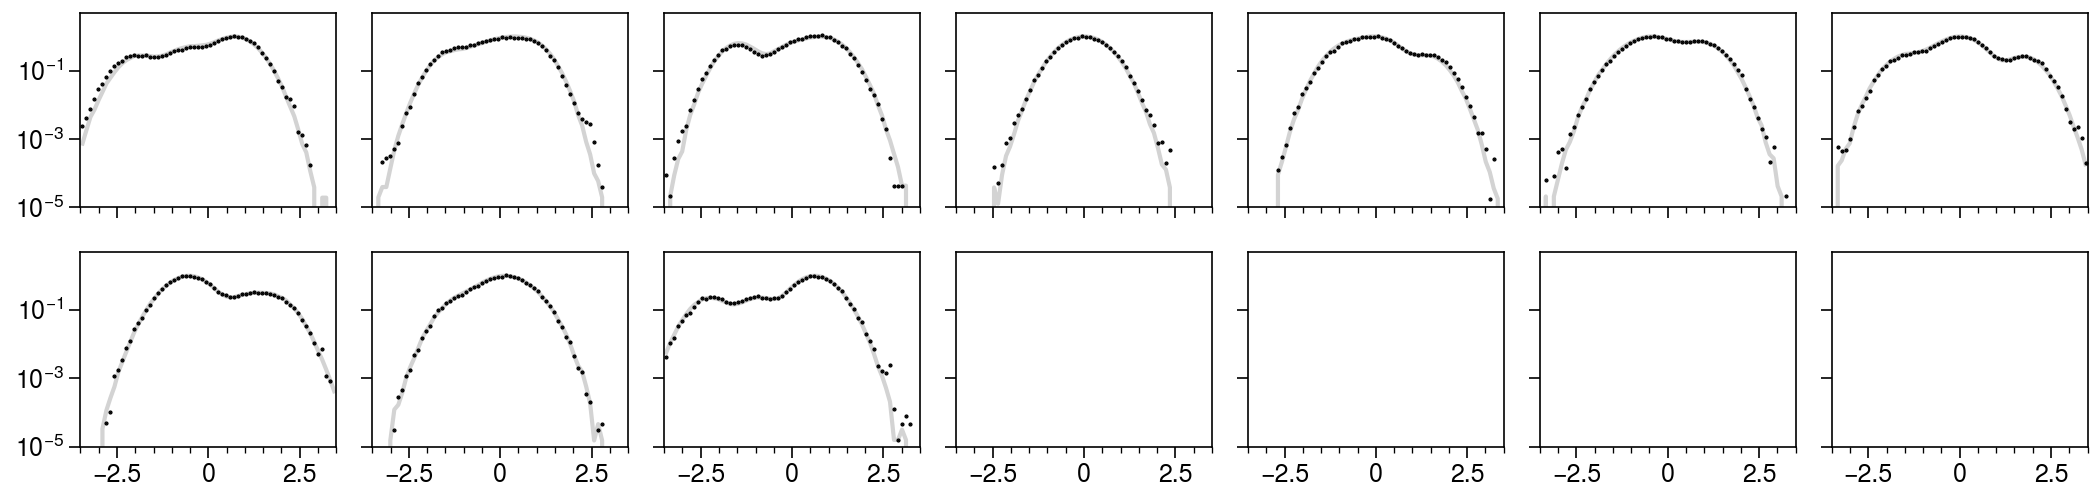

None


In [13]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=None,
    notebook=True,
)

trainer.train(epochs=3, learning_rate=0.80)